### AB42: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
### AB40: DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV


In [1]:
# !pip install MDAnalysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

In [ ]:
# 1. Confirmed that at pH 8.5, the NE1 nitrogen in histidine is protonated based on experimental data. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082993/

# 2. Changed aminoacids.c.tdb OH to OH1. Potential typo in force field files.

In [ ]:
# using hydrogen mass repartitioning for longer timesteps
gmx_mpi pdb2gmx -f template.pdb -o template.gro -ignh -heavyh -water tip3

cd setup

gmx_mpi editconf -f ../template.gro -o template_newbox.gro -c -d 2 -bt dodecahedron

gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top
# Number of solvent molecules:  13715

In [ ]:
# 1 – energy minimisation
# 2 – NVT 600K to get replica structures

In [ ]:
# Step 1
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c template_solv.gro -p ../topol.top -o em_input.tpr -maxwarn 2

# Got the following warning
# WARNING 1 [file ffnonbonded.itp, line 68]:
#   Atomtype OT was defined previously (e.g. in the forcefield files), and
#   has now been defined again. This could happen e.g. if you would use a
#   self-contained molecule .itp file that duplicates or replaces the
#   contents of the standard force-field files. You should check the contents
#   of your files and remove such repetition. If you know you should override
#   the previous definition, then you could choose to suppress this warningb
#   with -maxwarn.

gerun gmx_mpi mdrun -s em -v -maxh 5 &> em_terminal.log

In [ ]:
# Step 2

gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em_output.gro -r em_output.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr_terminal.log

In [ ]:
# Step 3

gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

In [ ]:
# Step 4

gmx_mpi grompp -f ../mdp_files/4-nvt-600.mdp -c em.gro -r em.gro -p ../topol.top -o 4-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal.log

# restarting step 4
gerun gmx_mpi mdrun -cpi 4-nvt-600 -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal-r2.log

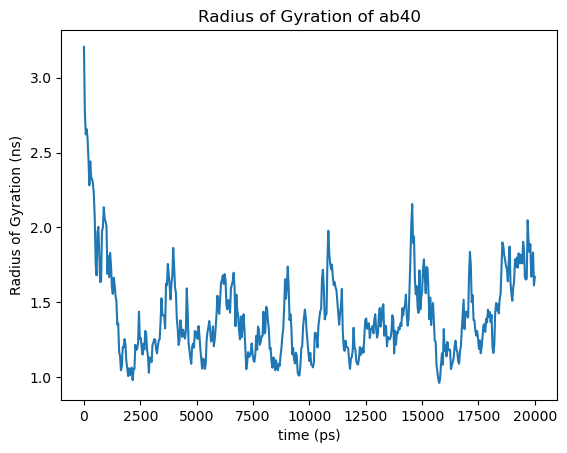

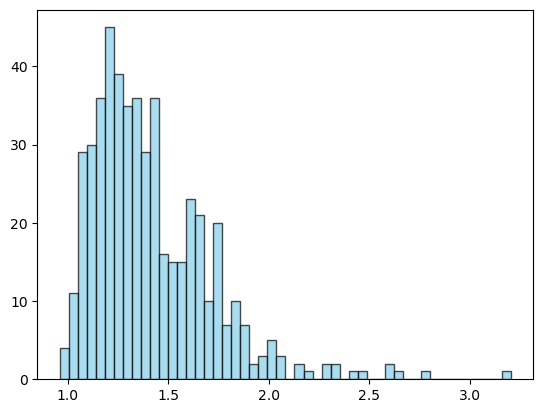

(array([1], dtype=int64),)
1.96781


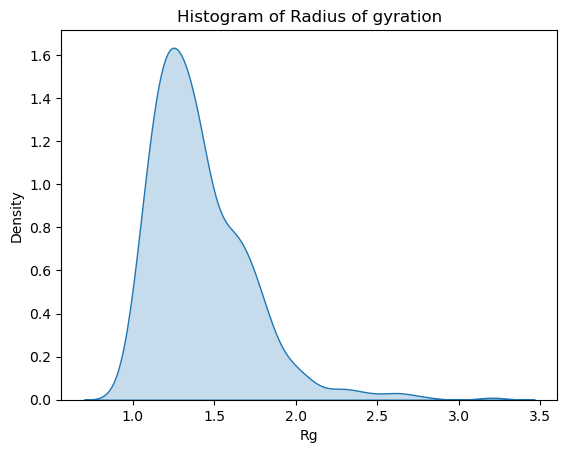

In [23]:
# Plotting the radius of gyration of the peptide in the trajectory

# gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600.trr -o 4-nvt-600-noPBC.trr -pbc mol -center

# gmx_mpi gyrate -s 4-nvt-600.gro -f 4-nvt-600-noPBC.trr -o 4-nvt-600-rgyr.xvg

data = pd.read_table("4-nvt-600-rgyr.xvg", delim_whitespace=True, skiprows=27, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

sorted_y = sorted(y)

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("Radius of Gyration (ns)")  # Add a y-label to the axes.
ax.set_title("Radius of Gyration of ab40")
plt.show()
plt.hist(sorted_y, bins=50, edgecolor='black', color='skyblue', alpha=0.7)

indices = np.where(y == 2.77667)
plt.show()

print(indices)
print(sorted_y[476])
import seaborn as sns
import matplotlib.pyplot as plt

# Create a KDE plot
sns.kdeplot(y, fill=True)

# Add title and labels
plt.title('Histogram of Radius of gyration')
plt.xlabel('Rg')
plt.ylabel('Density')

# Show the plot
plt.show()

# print(sorted_y)
# extract 476

In [ ]:
# extracting the frame with Rg 2.7 nm i.e. the second frame in the trajectory
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-frame2.gro -dump 40 # 40 = 40 ps

# extracting the frame with Rg 1.96781 i.e. the 95-percentile
gmx_mpi trjconv -s 4-nvt-600.tpr -f 4-nvt-600-noPBC.trr -o 4-nvt-600-noPBC-95-percentile-Rg.gro -dump 600 # 40 = 40 ps

In [79]:
trajectory = "4-nvt-600-noPBC.trr"
topology = "4-nvt-600.gro"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
first_frame = 0
n_frames=trj.n_frames

frame = trj2[0]
frame.save('linear-test.gro')
# frame.save('4-nvt-600-95-percentile-rg.gro')

# frame = trj[0]
# frame.save('5-nvt-600-noPBC-no-water-mf-frame1.gro')
# trj.save_trr('5-nvt-600-no-water-mf.trr')

# trj2 = trj.slice(range(0, 2001, 10))
# print(trj2.n_frames)

# rg = md.compute_rg(trj2, masses=None)
# rg[131]

In [80]:
frame = trj2[1]
frame.save('linear-test.gro')

In [ ]:
# extracting collapsed structure from trajectory using mdtraj


topology=f"4-nvt-600.gro"
trajectory=f"4-nvt-600.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj = trj.atom_slice(range(598))
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

print(n_frames)

frame = trj[454]
frame.save('454.gro')
 
# ended up using the frame with the 95th Percentile Rgyr

### procedure for the 600 K run to extract confirmations for production run

In [ ]:


# 1. adding water molecules
gmx_mpi editconf -f template.gro -o template_newbox.gro -c -d 1.8 -bt dodecahedron
gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top

# Output configuration contains 34906 atoms in 11476 residues
# Volume                 :     353.625 (nm^3)
# Density                :     989.107 (g/l)
# Number of solvent molecules:  11436

# 2. adding ions
gmx_mpi grompp -f ../mdp_files/ions.mdp -c template_solv.gro -p ../topol.top -o genion_NaCl_input.tpr -maxwarn 2
# WARNING 2 [file topol.top, line 5632]:
#   96 non-matching atom names
#   atom names from ../topol.top will be used
#   atom names from template_solv.gro will be ignored
gmx_mpi genion -s genion_NaCl_input.tpr -o genion_NaCl_output.gro -conc 0.137 -pname NA -nname CL -p ../topol.top

gmx_mpi grompp -f ../mdp_files/ions.mdp -c genion_NaCl_output.gro -p ../topol.top -o genion_KCl_input.tpr -maxwarn 1
gmx_mpi genion -s genion_KCl_input.tpr -o genion_KCl_output.gro -conc 0.00268 -pname K -nname CL -p ../topol.top
# no KCl ions added

# 3. Energy minimization
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c  genion_KCl_output.gro -p ../topol.top -o em.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm em -v -maxh 11 &> em-terminal.log

# 4. position restraints
gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em.gro -r em.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr-terminal.log
gmx_mpi mdrun -deffnm 2-pr -rcon 1.5 -dds 0.8 -v &> 2-pr-terminal.log
# There is no domain decomposition for 60 ranks that is compatible with the
# given box and a minimum cell size of 1.37088 nm
# Change the number of ranks or mdrun option -rcon or -dds or your LINCS
# settings
# Look in the log file for details on the domain decomposition

# Changed the number of ranks to 42

# 5. Berendsen
gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

# 6. nvt-600
gmx_mpi grompp -f ../mdp_files/5-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 5-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 5-nvt-600 -v &> 5-nvt-600-terminal.log


In [ ]:
# centering the trajectory with gromacs
gmx_mpi trjconv -s 5-nvt-600.tpr -f 5-nvt-600.trr -o 5-nvt-600-noPBC.trr -pbc mol -center

In [ ]:
# checking contacts between the peptide and its periodic images to see if box size is large enough
gmx_mpi mindist -f 5-nvt-600.trr -s 5-nvt-600.tpr -pi -od 5-nvt-600-mindist.xvg

# The shortest periodic distance is 2.26306 (nm) at time 1732 (ps),
# between atoms 107 and 622

4.503


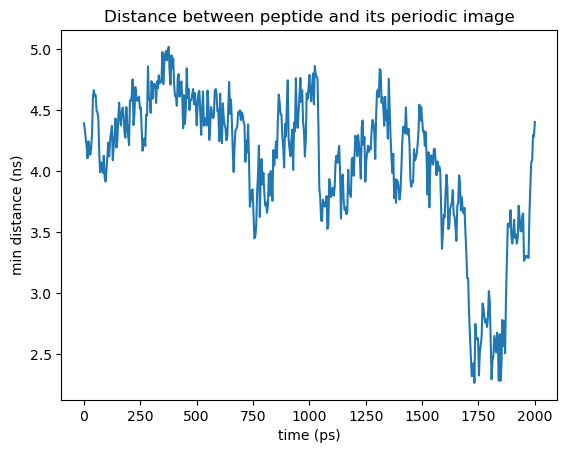

In [2]:

data = pd.read_table("setup/5-nvt-600-mindist.xvg", delim_whitespace=True, skiprows=29, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("min distance (ns)")  # Add a y-label to the axes.
ax.set_title("Distance between peptide and its periodic image")

print(y[131])

#### Extracting different confirmations

In [4]:
topology=f"setup/5-nvt-600.gro"
trajectory=f"setup/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(627))
# trj.center_coordinates()
top = trj2.topology
# n_frames=trj.n_frames
# n_frames

In [5]:
# # https://stackoverflow.com/questions/63321109/algorithm-for-selecting-a-subset-of-most-distant-elements
def find_largest_values(trj, N, M):
    candidates = []  # List to store pairs (j, l(j))
    S_prime = []  # Resulting subset

    # Calculate pairwise distances and initialize candidates list
    for i in range(N):
            rmsd = md.rmsd(trj, trj, i)
#             print(rmsd)
            rmsd = np.delete(rmsd, i)

            l_i = min(rmsd)
            candidates.append((i, l_i))

    # Sort candidates list by l(i) in descending order
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Select M elements with the largest values of l(i)
    for i in range(M):
        current_index, current_l_value = candidates[i]
        S_prime.append(current_index)

    return S_prime

indxs = find_largest_values(trj2, trj2.n_frames, 100)
indxs

[202,
 412,
 396,
 393,
 397,
 474,
 475,
 403,
 467,
 290,
 384,
 383,
 394,
 395,
 398,
 473,
 407,
 463,
 429,
 481,
 195,
 284,
 472,
 382,
 334,
 327,
 488,
 406,
 494,
 417,
 440,
 208,
 209,
 381,
 206,
 207,
 380,
 451,
 297,
 457,
 319,
 326,
 300,
 293,
 460,
 426,
 425,
 386,
 385,
 424,
 294,
 461,
 462,
 436,
 377,
 434,
 435,
 401,
 402,
 466,
 232,
 203,
 439,
 170,
 464,
 465,
 416,
 478,
 375,
 376,
 448,
 233,
 279,
 495,
 341,
 304,
 124,
 373,
 374,
 496,
 404,
 405,
 160,
 470,
 471,
 499,
 500,
 301,
 75,
 418,
 169,
 298,
 299,
 482,
 483,
 275,
 421,
 276,
 318,
 423]

In [7]:
for i in range(100):
    print(f"adding replica {i}")
    trj[indxs[i]].save(f'setup2/r{i}/replica.gro')

adding replica 0
adding replica 1
adding replica 2
adding replica 3
adding replica 4
adding replica 5
adding replica 6
adding replica 7
adding replica 8
adding replica 9
adding replica 10
adding replica 11
adding replica 12
adding replica 13
adding replica 14
adding replica 15
adding replica 16
adding replica 17
adding replica 18
adding replica 19
adding replica 20
adding replica 21
adding replica 22
adding replica 23
adding replica 24
adding replica 25
adding replica 26
adding replica 27
adding replica 28
adding replica 29
adding replica 30
adding replica 31
adding replica 32
adding replica 33
adding replica 34
adding replica 35
adding replica 36
adding replica 37
adding replica 38
adding replica 39
adding replica 40
adding replica 41
adding replica 42
adding replica 43
adding replica 44
adding replica 45
adding replica 46
adding replica 47
adding replica 48
adding replica 49
adding replica 50
adding replica 51
adding replica 52
adding replica 53
adding replica 54
adding replica 55
ad

#### Checking that the dihedrals are okay for all replicas

In [8]:
# Ensuring that all residues are in the trans confirmation
topology=f"setup/5-nvt-600.gro"
trajectory=f"setup/5-nvt-600-noPBC.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(627))

omega = md.compute_omega(trj2)
# omega[0]


In [13]:
print(len(omega))
print(len(omega[0]))
print(len(omega[1]))
print(omega[1][500])

for replica_indx in indxs:
    for angles in omega[1]:
        for angle in angles:
            if np.abs(angle) < 2.531:
                print(f'error in replica: {replica_indx}, angle: {angle}')

2
41
501
[-2.924137  -2.877989  -2.9932837  2.8312523 -3.039572  -3.075321
 -3.1103008 -3.004542  -3.1045854  2.8053675 -3.0494175  3.0084329
  2.9079227  2.7717614 -2.8799214  2.8848872 -3.1183915 -2.8359444
  3.0143063 -2.9669805  3.0938632  2.737762   3.0465283  3.0467207
 -2.8757634 -2.925773  -3.0730238  3.0313234 -3.0622313 -2.9683936
  2.89324   -3.0860212 -3.0425563 -3.1057003  2.781565   3.0552926
  3.1341548 -2.9255075  2.672416   2.9695137  2.913144 ]
error in replica: 202, angle: 2.513849973678589
error in replica: 202, angle: 2.513726234436035
error in replica: 202, angle: -2.5286049842834473
error in replica: 202, angle: -2.409868001937866
error in replica: 202, angle: 2.4963648319244385
error in replica: 202, angle: -2.270383834838867
error in replica: 202, angle: 2.46836256980896
error in replica: 202, angle: 2.498964309692383
error in replica: 202, angle: 2.44746994972229
error in replica: 202, angle: -2.5086400508880615
error in replica: 202, angle: -2.333429574966430

error in replica: 397, angle: -2.4993557929992676
error in replica: 397, angle: -2.507798194885254
error in replica: 397, angle: -2.4148058891296387
error in replica: 397, angle: 2.503448724746704
error in replica: 397, angle: -2.3003361225128174
error in replica: 397, angle: 2.508204698562622
error in replica: 474, angle: 2.513849973678589
error in replica: 474, angle: 2.513726234436035
error in replica: 474, angle: -2.5286049842834473
error in replica: 474, angle: -2.409868001937866
error in replica: 474, angle: 2.4963648319244385
error in replica: 474, angle: -2.270383834838867
error in replica: 474, angle: 2.46836256980896
error in replica: 474, angle: 2.498964309692383
error in replica: 474, angle: 2.44746994972229
error in replica: 474, angle: -2.5086400508880615
error in replica: 474, angle: -2.3334295749664307
error in replica: 474, angle: -2.5193591117858887
error in replica: 474, angle: -2.508661985397339
error in replica: 474, angle: -2.378920316696167
error in replica: 474,

error in replica: 467, angle: 2.460770606994629
error in replica: 467, angle: 2.3478283882141113
error in replica: 467, angle: -2.5099377632141113
error in replica: 467, angle: 2.3862991333007812
error in replica: 467, angle: 2.454137086868286
error in replica: 467, angle: -2.4446299076080322
error in replica: 467, angle: 2.264554977416992
error in replica: 467, angle: 2.465242385864258
error in replica: 467, angle: -2.4613280296325684
error in replica: 467, angle: 2.440749168395996
error in replica: 467, angle: -2.295088768005371
error in replica: 467, angle: 2.4777913093566895
error in replica: 467, angle: 2.503718376159668
error in replica: 467, angle: 2.440990924835205
error in replica: 467, angle: -2.381223678588867
error in replica: 467, angle: -2.5153582096099854
error in replica: 467, angle: 2.4990651607513428
error in replica: 467, angle: -2.318021535873413
error in replica: 467, angle: 2.2878382205963135
error in replica: 467, angle: 2.478205919265747
error in replica: 467, a

error in replica: 394, angle: 2.440749168395996
error in replica: 394, angle: -2.295088768005371
error in replica: 394, angle: 2.4777913093566895
error in replica: 394, angle: 2.503718376159668
error in replica: 394, angle: 2.440990924835205
error in replica: 394, angle: -2.381223678588867
error in replica: 394, angle: -2.5153582096099854
error in replica: 394, angle: 2.4990651607513428
error in replica: 394, angle: -2.318021535873413
error in replica: 394, angle: 2.2878382205963135
error in replica: 394, angle: 2.478205919265747
error in replica: 394, angle: 2.5148963928222656
error in replica: 394, angle: -2.4729554653167725
error in replica: 394, angle: 2.4970970153808594
error in replica: 394, angle: -2.464996576309204
error in replica: 394, angle: -2.4652597904205322
error in replica: 394, angle: -2.4420652389526367
error in replica: 394, angle: -2.513258695602417
error in replica: 394, angle: -2.4880168437957764
error in replica: 394, angle: -2.4787039756774902
error in replica: 

error in replica: 463, angle: 2.513849973678589
error in replica: 463, angle: 2.513726234436035
error in replica: 463, angle: -2.5286049842834473
error in replica: 463, angle: -2.409868001937866
error in replica: 463, angle: 2.4963648319244385
error in replica: 463, angle: -2.270383834838867
error in replica: 463, angle: 2.46836256980896
error in replica: 463, angle: 2.498964309692383
error in replica: 463, angle: 2.44746994972229
error in replica: 463, angle: -2.5086400508880615
error in replica: 463, angle: -2.3334295749664307
error in replica: 463, angle: -2.5193591117858887
error in replica: 463, angle: -2.508661985397339
error in replica: 463, angle: -2.378920316696167
error in replica: 463, angle: -2.518516778945923
error in replica: 463, angle: -2.4463446140289307
error in replica: 463, angle: 2.465059995651245
error in replica: 463, angle: -2.4260847568511963
error in replica: 463, angle: -2.4917173385620117
error in replica: 463, angle: 2.365844964981079
error in replica: 463,

error in replica: 284, angle: -2.4391849040985107
error in replica: 284, angle: -2.503814697265625
error in replica: 284, angle: 2.4174609184265137
error in replica: 284, angle: -2.487590789794922
error in replica: 284, angle: -2.4703400135040283
error in replica: 284, angle: -2.4976208209991455
error in replica: 284, angle: -2.4489216804504395
error in replica: 284, angle: 2.5258617401123047
error in replica: 284, angle: -2.4936482906341553
error in replica: 284, angle: -2.521409273147583
error in replica: 284, angle: 2.4210307598114014
error in replica: 284, angle: -2.481410264968872
error in replica: 284, angle: -2.3241324424743652
error in replica: 284, angle: -2.4786698818206787
error in replica: 284, angle: 2.5068860054016113
error in replica: 284, angle: -2.449800729751587
error in replica: 284, angle: -2.5198583602905273
error in replica: 284, angle: -2.527879238128662
error in replica: 284, angle: -2.491935968399048
error in replica: 284, angle: -2.459522247314453
error in rep

error in replica: 327, angle: 2.3864734172821045
error in replica: 327, angle: 2.5235543251037598
error in replica: 327, angle: -2.4576754570007324
error in replica: 327, angle: 2.508220672607422
error in replica: 327, angle: 2.49855375289917
error in replica: 327, angle: -2.52091383934021
error in replica: 327, angle: -2.504948854446411
error in replica: 327, angle: -2.4557442665100098
error in replica: 327, angle: 2.5176661014556885
error in replica: 327, angle: -2.50777268409729
error in replica: 327, angle: -2.5064282417297363
error in replica: 327, angle: -2.519728183746338
error in replica: 327, angle: -2.458662271499634
error in replica: 327, angle: 2.460770606994629
error in replica: 327, angle: 2.3478283882141113
error in replica: 327, angle: -2.5099377632141113
error in replica: 327, angle: 2.3862991333007812
error in replica: 327, angle: 2.454137086868286
error in replica: 327, angle: -2.4446299076080322
error in replica: 327, angle: 2.264554977416992
error in replica: 327, 

error in replica: 417, angle: -2.381223678588867
error in replica: 417, angle: -2.5153582096099854
error in replica: 417, angle: 2.4990651607513428
error in replica: 417, angle: -2.318021535873413
error in replica: 417, angle: 2.2878382205963135
error in replica: 417, angle: 2.478205919265747
error in replica: 417, angle: 2.5148963928222656
error in replica: 417, angle: -2.4729554653167725
error in replica: 417, angle: 2.4970970153808594
error in replica: 417, angle: -2.464996576309204
error in replica: 417, angle: -2.4652597904205322
error in replica: 417, angle: -2.4420652389526367
error in replica: 417, angle: -2.513258695602417
error in replica: 417, angle: -2.4880168437957764
error in replica: 417, angle: -2.4787039756774902
error in replica: 417, angle: 2.380993127822876
error in replica: 417, angle: 2.498173236846924
error in replica: 417, angle: -2.4575178623199463
error in replica: 417, angle: 2.480175018310547
error in replica: 417, angle: 2.528585433959961
error in replica: 

error in replica: 381, angle: 2.365844964981079
error in replica: 381, angle: -2.50961971282959
error in replica: 381, angle: 2.4321939945220947
error in replica: 381, angle: -2.5295681953430176
error in replica: 381, angle: -2.471060276031494
error in replica: 381, angle: -2.4598872661590576
error in replica: 381, angle: -2.4391849040985107
error in replica: 381, angle: -2.503814697265625
error in replica: 381, angle: 2.4174609184265137
error in replica: 381, angle: -2.487590789794922
error in replica: 381, angle: -2.4703400135040283
error in replica: 381, angle: -2.4976208209991455
error in replica: 381, angle: -2.4489216804504395
error in replica: 381, angle: 2.5258617401123047
error in replica: 381, angle: -2.4936482906341553
error in replica: 381, angle: -2.521409273147583
error in replica: 381, angle: 2.4210307598114014
error in replica: 381, angle: -2.481410264968872
error in replica: 381, angle: -2.3241324424743652
error in replica: 381, angle: -2.4786698818206787
error in repl

error in replica: 380, angle: -2.403961658477783
error in replica: 380, angle: 2.5281262397766113
error in replica: 380, angle: -2.447740316390991
error in replica: 380, angle: -2.441713333129883
error in replica: 380, angle: -2.468876600265503
error in replica: 380, angle: -2.4173197746276855
error in replica: 380, angle: -2.5095298290252686
error in replica: 380, angle: 2.493981122970581
error in replica: 380, angle: -2.3819236755371094
error in replica: 380, angle: 2.5182058811187744
error in replica: 380, angle: -2.510002613067627
error in replica: 380, angle: -2.490729331970215
error in replica: 380, angle: -2.504795551300049
error in replica: 380, angle: 2.508967399597168
error in replica: 380, angle: -2.4834144115448
error in replica: 380, angle: -2.413357734680176
error in replica: 380, angle: -2.52897310256958
error in replica: 380, angle: 2.4993677139282227
error in replica: 380, angle: 2.3864734172821045
error in replica: 380, angle: 2.5235543251037598
error in replica: 380,

error in replica: 319, angle: 2.508220672607422
error in replica: 319, angle: 2.49855375289917
error in replica: 319, angle: -2.52091383934021
error in replica: 319, angle: -2.504948854446411
error in replica: 319, angle: -2.4557442665100098
error in replica: 319, angle: 2.5176661014556885
error in replica: 319, angle: -2.50777268409729
error in replica: 319, angle: -2.5064282417297363
error in replica: 319, angle: -2.519728183746338
error in replica: 319, angle: -2.458662271499634
error in replica: 319, angle: 2.460770606994629
error in replica: 319, angle: 2.3478283882141113
error in replica: 319, angle: -2.5099377632141113
error in replica: 319, angle: 2.3862991333007812
error in replica: 319, angle: 2.454137086868286
error in replica: 319, angle: -2.4446299076080322
error in replica: 319, angle: 2.264554977416992
error in replica: 319, angle: 2.465242385864258
error in replica: 319, angle: -2.4613280296325684
error in replica: 319, angle: 2.440749168395996
error in replica: 319, an

error in replica: 460, angle: 2.503448724746704
error in replica: 460, angle: -2.3003361225128174
error in replica: 460, angle: 2.508204698562622
error in replica: 426, angle: 2.513849973678589
error in replica: 426, angle: 2.513726234436035
error in replica: 426, angle: -2.5286049842834473
error in replica: 426, angle: -2.409868001937866
error in replica: 426, angle: 2.4963648319244385
error in replica: 426, angle: -2.270383834838867
error in replica: 426, angle: 2.46836256980896
error in replica: 426, angle: 2.498964309692383
error in replica: 426, angle: 2.44746994972229
error in replica: 426, angle: -2.5086400508880615
error in replica: 426, angle: -2.3334295749664307
error in replica: 426, angle: -2.5193591117858887
error in replica: 426, angle: -2.508661985397339
error in replica: 426, angle: -2.378920316696167
error in replica: 426, angle: -2.518516778945923
error in replica: 426, angle: -2.4463446140289307
error in replica: 426, angle: 2.465059995651245
error in replica: 426, a

error in replica: 385, angle: -2.3334295749664307
error in replica: 385, angle: -2.5193591117858887
error in replica: 385, angle: -2.508661985397339
error in replica: 385, angle: -2.378920316696167
error in replica: 385, angle: -2.518516778945923
error in replica: 385, angle: -2.4463446140289307
error in replica: 385, angle: 2.465059995651245
error in replica: 385, angle: -2.4260847568511963
error in replica: 385, angle: -2.4917173385620117
error in replica: 385, angle: 2.365844964981079
error in replica: 385, angle: -2.50961971282959
error in replica: 385, angle: 2.4321939945220947
error in replica: 385, angle: -2.5295681953430176
error in replica: 385, angle: -2.471060276031494
error in replica: 385, angle: -2.4598872661590576
error in replica: 385, angle: -2.4391849040985107
error in replica: 385, angle: -2.503814697265625
error in replica: 385, angle: 2.4174609184265137
error in replica: 385, angle: -2.487590789794922
error in replica: 385, angle: -2.4703400135040283
error in repli

error in replica: 462, angle: -2.481410264968872
error in replica: 462, angle: -2.3241324424743652
error in replica: 462, angle: -2.4786698818206787
error in replica: 462, angle: 2.5068860054016113
error in replica: 462, angle: -2.449800729751587
error in replica: 462, angle: -2.5198583602905273
error in replica: 462, angle: -2.527879238128662
error in replica: 462, angle: -2.491935968399048
error in replica: 462, angle: -2.459522247314453
error in replica: 462, angle: 2.4894957542419434
error in replica: 462, angle: -2.403961658477783
error in replica: 462, angle: 2.5281262397766113
error in replica: 462, angle: -2.447740316390991
error in replica: 462, angle: -2.441713333129883
error in replica: 462, angle: -2.468876600265503
error in replica: 462, angle: -2.4173197746276855
error in replica: 462, angle: -2.5095298290252686
error in replica: 462, angle: 2.493981122970581
error in replica: 462, angle: -2.3819236755371094
error in replica: 462, angle: 2.5182058811187744
error in replic

error in replica: 435, angle: 2.454137086868286
error in replica: 435, angle: -2.4446299076080322
error in replica: 435, angle: 2.264554977416992
error in replica: 435, angle: 2.465242385864258
error in replica: 435, angle: -2.4613280296325684
error in replica: 435, angle: 2.440749168395996
error in replica: 435, angle: -2.295088768005371
error in replica: 435, angle: 2.4777913093566895
error in replica: 435, angle: 2.503718376159668
error in replica: 435, angle: 2.440990924835205
error in replica: 435, angle: -2.381223678588867
error in replica: 435, angle: -2.5153582096099854
error in replica: 435, angle: 2.4990651607513428
error in replica: 435, angle: -2.318021535873413
error in replica: 435, angle: 2.2878382205963135
error in replica: 435, angle: 2.478205919265747
error in replica: 435, angle: 2.5148963928222656
error in replica: 435, angle: -2.4729554653167725
error in replica: 435, angle: 2.4970970153808594
error in replica: 435, angle: -2.464996576309204
error in replica: 435, 

error in replica: 232, angle: -2.4936482906341553
error in replica: 232, angle: -2.521409273147583
error in replica: 232, angle: 2.4210307598114014
error in replica: 232, angle: -2.481410264968872
error in replica: 232, angle: -2.3241324424743652
error in replica: 232, angle: -2.4786698818206787
error in replica: 232, angle: 2.5068860054016113
error in replica: 232, angle: -2.449800729751587
error in replica: 232, angle: -2.5198583602905273
error in replica: 232, angle: -2.527879238128662
error in replica: 232, angle: -2.491935968399048
error in replica: 232, angle: -2.459522247314453
error in replica: 232, angle: 2.4894957542419434
error in replica: 232, angle: -2.403961658477783
error in replica: 232, angle: 2.5281262397766113
error in replica: 232, angle: -2.447740316390991
error in replica: 232, angle: -2.441713333129883
error in replica: 232, angle: -2.468876600265503
error in replica: 232, angle: -2.4173197746276855
error in replica: 232, angle: -2.5095298290252686
error in repli

error in replica: 464, angle: -2.52091383934021
error in replica: 464, angle: -2.504948854446411
error in replica: 464, angle: -2.4557442665100098
error in replica: 464, angle: 2.5176661014556885
error in replica: 464, angle: -2.50777268409729
error in replica: 464, angle: -2.5064282417297363
error in replica: 464, angle: -2.519728183746338
error in replica: 464, angle: -2.458662271499634
error in replica: 464, angle: 2.460770606994629
error in replica: 464, angle: 2.3478283882141113
error in replica: 464, angle: -2.5099377632141113
error in replica: 464, angle: 2.3862991333007812
error in replica: 464, angle: 2.454137086868286
error in replica: 464, angle: -2.4446299076080322
error in replica: 464, angle: 2.264554977416992
error in replica: 464, angle: 2.465242385864258
error in replica: 464, angle: -2.4613280296325684
error in replica: 464, angle: 2.440749168395996
error in replica: 464, angle: -2.295088768005371
error in replica: 464, angle: 2.4777913093566895
error in replica: 464,

error in replica: 375, angle: 2.454137086868286
error in replica: 375, angle: -2.4446299076080322
error in replica: 375, angle: 2.264554977416992
error in replica: 375, angle: 2.465242385864258
error in replica: 375, angle: -2.4613280296325684
error in replica: 375, angle: 2.440749168395996
error in replica: 375, angle: -2.295088768005371
error in replica: 375, angle: 2.4777913093566895
error in replica: 375, angle: 2.503718376159668
error in replica: 375, angle: 2.440990924835205
error in replica: 375, angle: -2.381223678588867
error in replica: 375, angle: -2.5153582096099854
error in replica: 375, angle: 2.4990651607513428
error in replica: 375, angle: -2.318021535873413
error in replica: 375, angle: 2.2878382205963135
error in replica: 375, angle: 2.478205919265747
error in replica: 375, angle: 2.5148963928222656
error in replica: 375, angle: -2.4729554653167725
error in replica: 375, angle: 2.4970970153808594
error in replica: 375, angle: -2.464996576309204
error in replica: 375, 

error in replica: 279, angle: -2.52091383934021
error in replica: 279, angle: -2.504948854446411
error in replica: 279, angle: -2.4557442665100098
error in replica: 279, angle: 2.5176661014556885
error in replica: 279, angle: -2.50777268409729
error in replica: 279, angle: -2.5064282417297363
error in replica: 279, angle: -2.519728183746338
error in replica: 279, angle: -2.458662271499634
error in replica: 279, angle: 2.460770606994629
error in replica: 279, angle: 2.3478283882141113
error in replica: 279, angle: -2.5099377632141113
error in replica: 279, angle: 2.3862991333007812
error in replica: 279, angle: 2.454137086868286
error in replica: 279, angle: -2.4446299076080322
error in replica: 279, angle: 2.264554977416992
error in replica: 279, angle: 2.465242385864258
error in replica: 279, angle: -2.4613280296325684
error in replica: 279, angle: 2.440749168395996
error in replica: 279, angle: -2.295088768005371
error in replica: 279, angle: 2.4777913093566895
error in replica: 279,

error in replica: 124, angle: 2.503448724746704
error in replica: 124, angle: -2.3003361225128174
error in replica: 124, angle: 2.508204698562622
error in replica: 373, angle: 2.513849973678589
error in replica: 373, angle: 2.513726234436035
error in replica: 373, angle: -2.5286049842834473
error in replica: 373, angle: -2.409868001937866
error in replica: 373, angle: 2.4963648319244385
error in replica: 373, angle: -2.270383834838867
error in replica: 373, angle: 2.46836256980896
error in replica: 373, angle: 2.498964309692383
error in replica: 373, angle: 2.44746994972229
error in replica: 373, angle: -2.5086400508880615
error in replica: 373, angle: -2.3334295749664307
error in replica: 373, angle: -2.5193591117858887
error in replica: 373, angle: -2.508661985397339
error in replica: 373, angle: -2.378920316696167
error in replica: 373, angle: -2.518516778945923
error in replica: 373, angle: -2.4463446140289307
error in replica: 373, angle: 2.465059995651245
error in replica: 373, a

error in replica: 405, angle: 2.465059995651245
error in replica: 405, angle: -2.4260847568511963
error in replica: 405, angle: -2.4917173385620117
error in replica: 405, angle: 2.365844964981079
error in replica: 405, angle: -2.50961971282959
error in replica: 405, angle: 2.4321939945220947
error in replica: 405, angle: -2.5295681953430176
error in replica: 405, angle: -2.471060276031494
error in replica: 405, angle: -2.4598872661590576
error in replica: 405, angle: -2.4391849040985107
error in replica: 405, angle: -2.503814697265625
error in replica: 405, angle: 2.4174609184265137
error in replica: 405, angle: -2.487590789794922
error in replica: 405, angle: -2.4703400135040283
error in replica: 405, angle: -2.4976208209991455
error in replica: 405, angle: -2.4489216804504395
error in replica: 405, angle: 2.5258617401123047
error in replica: 405, angle: -2.4936482906341553
error in replica: 405, angle: -2.521409273147583
error in replica: 405, angle: 2.4210307598114014
error in repli

error in replica: 500, angle: 2.365844964981079
error in replica: 500, angle: -2.50961971282959
error in replica: 500, angle: 2.4321939945220947
error in replica: 500, angle: -2.5295681953430176
error in replica: 500, angle: -2.471060276031494
error in replica: 500, angle: -2.4598872661590576
error in replica: 500, angle: -2.4391849040985107
error in replica: 500, angle: -2.503814697265625
error in replica: 500, angle: 2.4174609184265137
error in replica: 500, angle: -2.487590789794922
error in replica: 500, angle: -2.4703400135040283
error in replica: 500, angle: -2.4976208209991455
error in replica: 500, angle: -2.4489216804504395
error in replica: 500, angle: 2.5258617401123047
error in replica: 500, angle: -2.4936482906341553
error in replica: 500, angle: -2.521409273147583
error in replica: 500, angle: 2.4210307598114014
error in replica: 500, angle: -2.481410264968872
error in replica: 500, angle: -2.3241324424743652
error in replica: 500, angle: -2.4786698818206787
error in repl

error in replica: 169, angle: 2.3864734172821045
error in replica: 169, angle: 2.5235543251037598
error in replica: 169, angle: -2.4576754570007324
error in replica: 169, angle: 2.508220672607422
error in replica: 169, angle: 2.49855375289917
error in replica: 169, angle: -2.52091383934021
error in replica: 169, angle: -2.504948854446411
error in replica: 169, angle: -2.4557442665100098
error in replica: 169, angle: 2.5176661014556885
error in replica: 169, angle: -2.50777268409729
error in replica: 169, angle: -2.5064282417297363
error in replica: 169, angle: -2.519728183746338
error in replica: 169, angle: -2.458662271499634
error in replica: 169, angle: 2.460770606994629
error in replica: 169, angle: 2.3478283882141113
error in replica: 169, angle: -2.5099377632141113
error in replica: 169, angle: 2.3862991333007812
error in replica: 169, angle: 2.454137086868286
error in replica: 169, angle: -2.4446299076080322
error in replica: 169, angle: 2.264554977416992
error in replica: 169, 

error in replica: 483, angle: 2.4674746990203857
error in replica: 483, angle: -2.4858486652374268
error in replica: 483, angle: 2.528158664703369
error in replica: 483, angle: -2.47072696685791
error in replica: 483, angle: 2.3220040798187256
error in replica: 483, angle: -2.4993557929992676
error in replica: 483, angle: -2.507798194885254
error in replica: 483, angle: -2.4148058891296387
error in replica: 483, angle: 2.503448724746704
error in replica: 483, angle: -2.3003361225128174
error in replica: 483, angle: 2.508204698562622
error in replica: 275, angle: 2.513849973678589
error in replica: 275, angle: 2.513726234436035
error in replica: 275, angle: -2.5286049842834473
error in replica: 275, angle: -2.409868001937866
error in replica: 275, angle: 2.4963648319244385
error in replica: 275, angle: -2.270383834838867
error in replica: 275, angle: 2.46836256980896
error in replica: 275, angle: 2.498964309692383
error in replica: 275, angle: 2.44746994972229
error in replica: 275, ang

error in replica: 423, angle: 2.44746994972229
error in replica: 423, angle: -2.5086400508880615
error in replica: 423, angle: -2.3334295749664307
error in replica: 423, angle: -2.5193591117858887
error in replica: 423, angle: -2.508661985397339
error in replica: 423, angle: -2.378920316696167
error in replica: 423, angle: -2.518516778945923
error in replica: 423, angle: -2.4463446140289307
error in replica: 423, angle: 2.465059995651245
error in replica: 423, angle: -2.4260847568511963
error in replica: 423, angle: -2.4917173385620117
error in replica: 423, angle: 2.365844964981079
error in replica: 423, angle: -2.50961971282959
error in replica: 423, angle: 2.4321939945220947
error in replica: 423, angle: -2.5295681953430176
error in replica: 423, angle: -2.471060276031494
error in replica: 423, angle: -2.4598872661590576
error in replica: 423, angle: -2.4391849040985107
error in replica: 423, angle: -2.503814697265625
error in replica: 423, angle: 2.4174609184265137
error in replica

In [ ]:
# after extracting 100 confirmations, perform nvt and npt equilibration

# Carrying out NVT for 500 ps for each replica

# 1. NVT
gmx_mpi grompp -f ../mdp_files/6-nvt-278.mdp -c r0/replica.gro -p ../topol.top -o r0/nvt.tpr -maxwarn 3
for i in {1..99}; do gmx_mpi grompp -f ../mdp_files/6-nvt-278.mdp -c r${i}/replica.gro -p ../topol.top -o r${i}/nvt.tpr -maxwarn 3; done
gerun gmx_mpi mdrun -multidir r{0..99} -deffnm nvt -v -maxh 11 &> 6-nvt-278-terminal.log


# 3. NPT, nsteps = 1000000
gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r0/nvt.gro -p ../topol.top -o r0/npt.tpr -maxwarn 2
for i in {1..99}; do gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r${i}/nvt.gro -p ../topol.top -o r${i}/npt.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt -v &> 7-npt-278-terminal.log


# 3.2 NPT 2
gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r0/npt.gro -p ../topol.top -o r0/npt2.tpr -maxwarn 2
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/7-npt-278.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/npt2.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt2 -v &> 8-npt-278-terminal.log

# 3.3 NPT 5 fs
gmx_mpi grompp -f ../mdp_files/9-npt-278-5fs.mdp -c r0/npt.gro -p ../topol.top -o r0/npt-5fs-test.tpr -maxwarn 2
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/9-npt-278-5fs.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/npt-5fs.tpr -maxwarn 2; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm npt-5fs -v &> 9-npt-278-5fs-terminal.log



In [19]:
# checking the cis-trans configuration of confirmations after NVT and NPT equilibration
counter = 0

test_angle = (140/180) * np.pi

for i in range(100):
    structure = md.load(f"setup2/r{i}/npt.gro")
    omega = md.compute_omega(structure)
    print(f"checking replica {i}")
    angles = omega[1][0]
    indices = omega[0]
#     print(angles)
    flag = 0
    for j in range(len(angles)):
        angle = angles[j]
        if -test_angle < angle < test_angle:
            if flag == 0: 
                counter += 1
                flag = 1
                
            print(f'error in replica: {i} with residue {j}')
            print(indices[j])

counter

C:\Users\dell\anaconda3\envs\md\lib\site-packages\mdtraj\utils\validation.py:116: TypeCastPerformanceWarning: Casting unitcell_vectors dtype=float64 to <class 'numpy.float32'> 
  TypeCastPerformanceWarning)


checking replica 0
checking replica 1
checking replica 2
checking replica 3
checking replica 4
checking replica 5
checking replica 6
checking replica 7
checking replica 8
checking replica 9
checking replica 10
checking replica 11
checking replica 12
checking replica 13
checking replica 14
checking replica 15
checking replica 16
checking replica 17
checking replica 18
checking replica 19
checking replica 20
checking replica 21
checking replica 22
checking replica 23
checking replica 24
checking replica 25
checking replica 26
checking replica 27
checking replica 28
checking replica 29
checking replica 30
checking replica 31
checking replica 32
checking replica 33
checking replica 34
checking replica 35
checking replica 36
checking replica 37
checking replica 38
checking replica 39
checking replica 40
checking replica 41
checking replica 42
checking replica 43
checking replica 44
checking replica 45
checking replica 46
checking replica 47
checking replica 48
checking replica 49
checking r

0

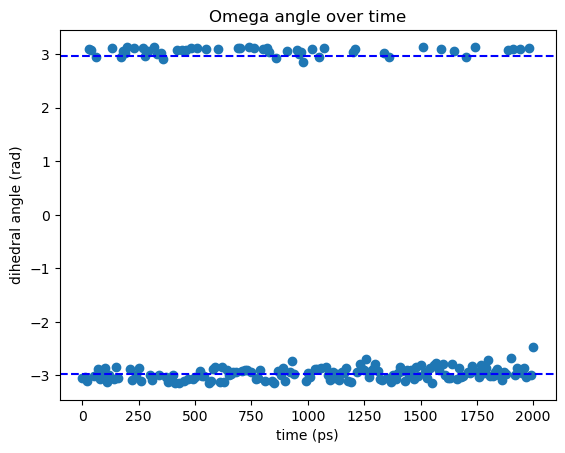

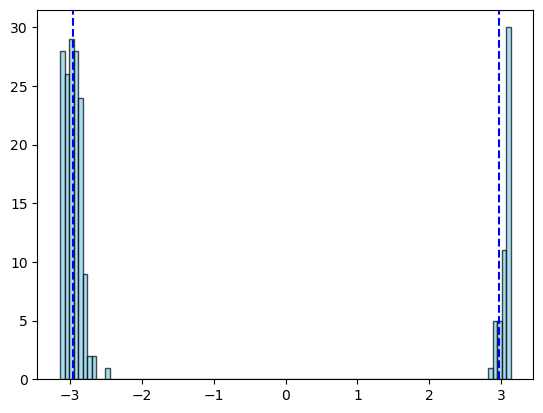

79
In frame 6, dihedral angle of residue 27 is 168.83902511267027
In frame 7, dihedral angle of residue 27 is -164.63472948982562
In frame 10, dihedral angle of residue 27 is -163.62226322839794
In frame 15, dihedral angle of residue 27 is -162.4350943883797
In frame 17, dihedral angle of residue 27 is 168.50714622089936
In frame 21, dihedral angle of residue 27 is -165.0395001604189
In frame 25, dihedral angle of residue 27 is -163.8910858137513
In frame 28, dihedral angle of residue 27 is 169.8610672993143
In frame 36, dihedral angle of residue 27 is 167.27470688706225
In frame 52, dihedral angle of residue 27 is -167.16292401110584
In frame 58, dihedral angle of residue 27 is -165.14852363995064
In frame 59, dihedral angle of residue 27 is -163.04975677216748
In frame 62, dihedral angle of residue 27 is -162.70225040757558
In frame 64, dihedral angle of residue 27 is -166.444046600962
In frame 67, dihedral angle of residue 27 is -168.56115935685582
In frame 68, dihedral angle of res

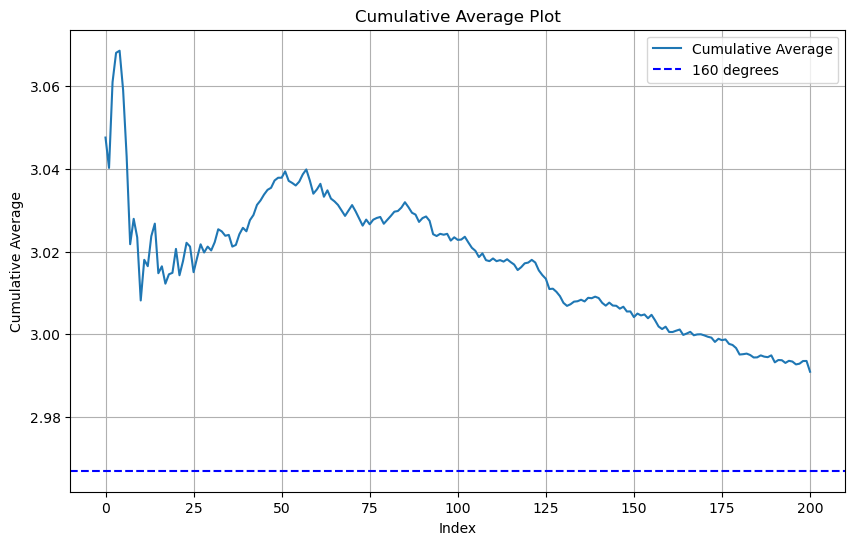

In [18]:
replica = 78
res = 27

angle = (170/180) * np.pi

topology=f"setup2/r{replica}/npt.gro"
trajectory=f"setup2/r{replica}/npt.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(627))

omega = md.compute_omega(trj2)

res_3_omega = [angles[res] for angles in omega[1]]

x = np.linspace(0, 2000, 201)

fig, ax = plt.subplots()
ax.scatter(x, res_3_omega)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("dihedral angle (rad)")  # Add a y-label to the axes.
ax.set_title("Omega angle over time")
plt.axhline(y=angle, color='b', linestyle='--')
plt.axhline(y=-1*angle, color='b', linestyle='--')
plt.show()

plt.hist(res_3_omega, bins=100, edgecolor='black', color='skyblue', alpha=0.7)
plt.axvline(x=angle, color='b', linestyle='--')
plt.axvline(x=-1*angle, color='b', linestyle='--')
plt.show()

res_3_omega = np.array(res_3_omega)
outliers = np.where((res_3_omega > (-1 * angle)) & (res_3_omega < angle))

print(len(outliers[0]))
for i in range(len(outliers[0])):
    print(f"In frame {outliers[0][i]}, dihedral angle of residue {res} is {res_3_omega[outliers[0][i]] * 180/np.pi}")
    

res_3_omega = np.abs(res_3_omega)
cumulative_average = np.cumsum(res_3_omega) / np.arange(1, len(res_3_omega) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_average, label='Cumulative Average')
plt.xlabel('Index')
plt.ylabel('Cumulative Average')
plt.axhline(y=angle, color='b', linestyle='--', label = "160 degrees")
plt.title('Cumulative Average Plot')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Checking Ramachandran plot of the peptide
indxs[0]

4

plotting Ramachandran plot of Replica 0


C:\Users\dell\anaconda3\envs\md\lib\site-packages\MDAnalysis\coordinates\base.py:892: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


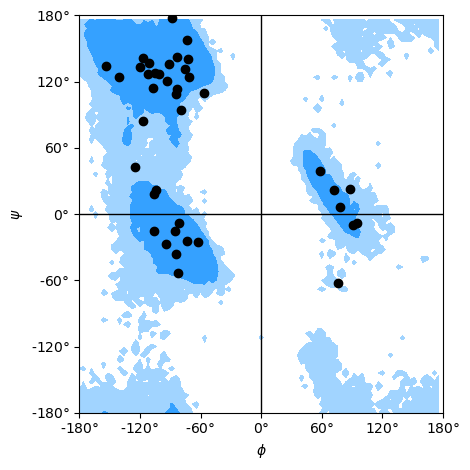

plotting Ramachandran plot of Replica 1


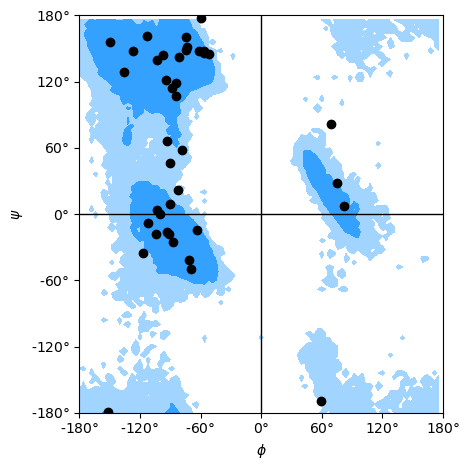

plotting Ramachandran plot of Replica 2


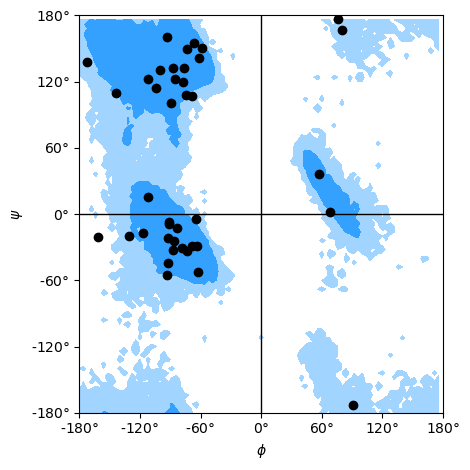

plotting Ramachandran plot of Replica 3


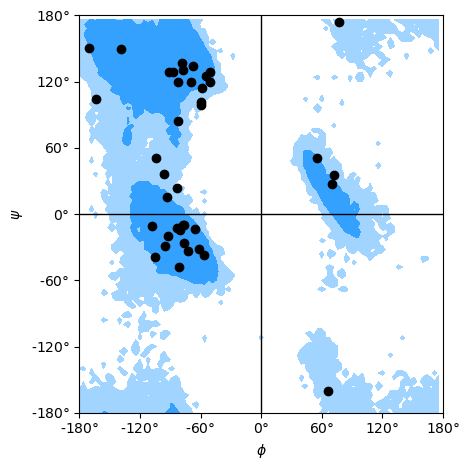

plotting Ramachandran plot of Replica 4


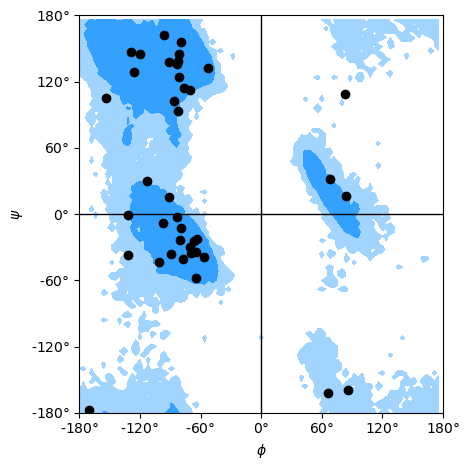

plotting Ramachandran plot of Replica 5


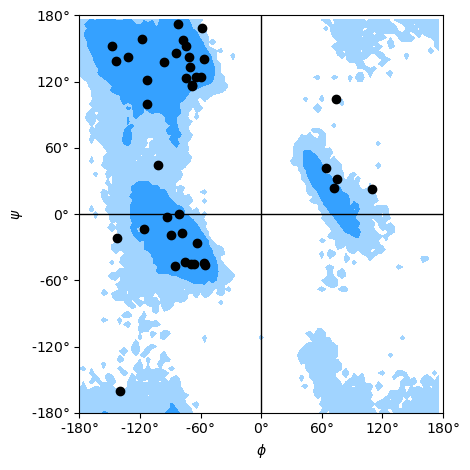

plotting Ramachandran plot of Replica 6


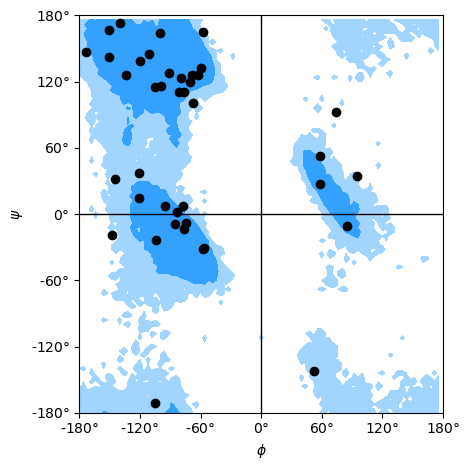

plotting Ramachandran plot of Replica 7


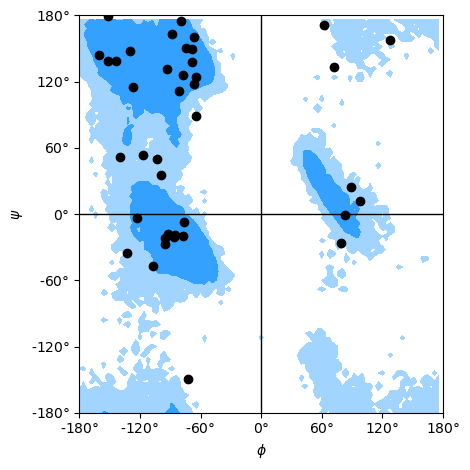

plotting Ramachandran plot of Replica 8


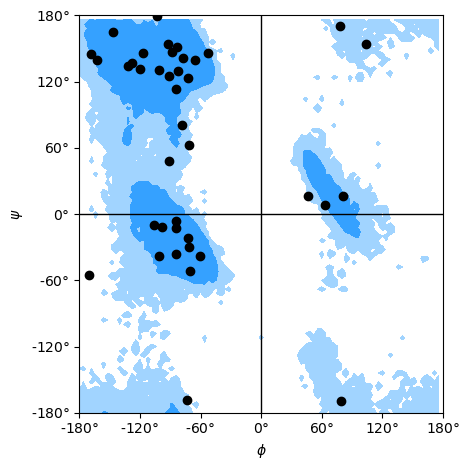

plotting Ramachandran plot of Replica 9


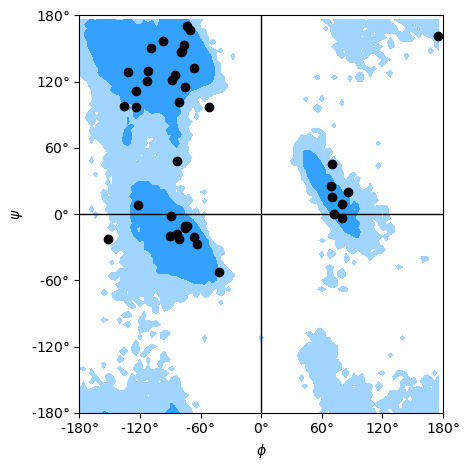

plotting Ramachandran plot of Replica 10


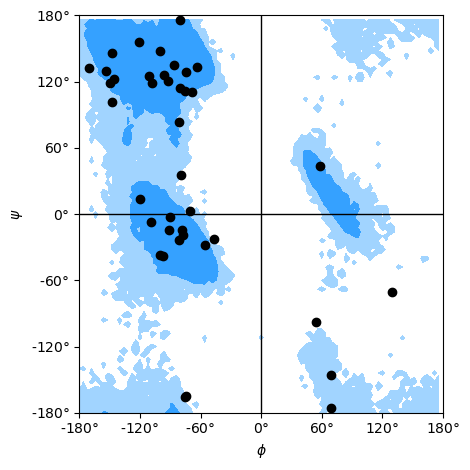

plotting Ramachandran plot of Replica 11


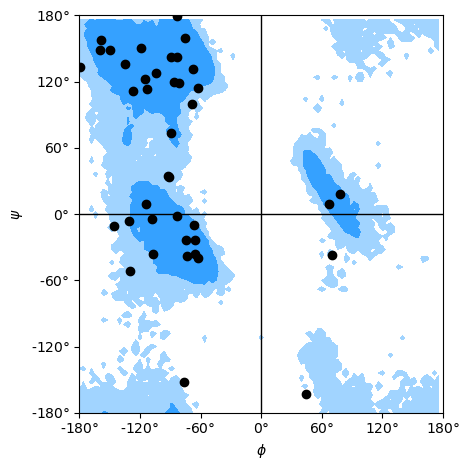

plotting Ramachandran plot of Replica 12


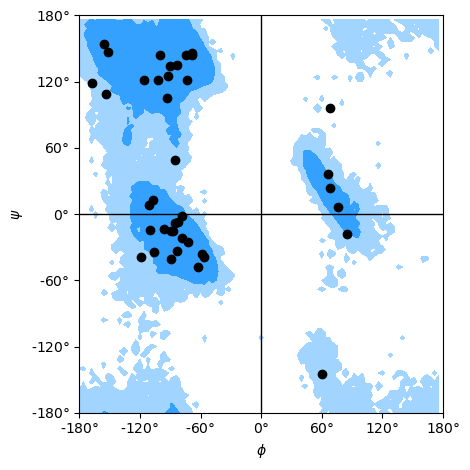

plotting Ramachandran plot of Replica 13


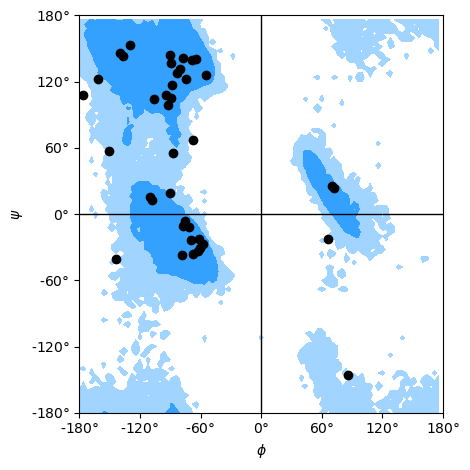

plotting Ramachandran plot of Replica 14


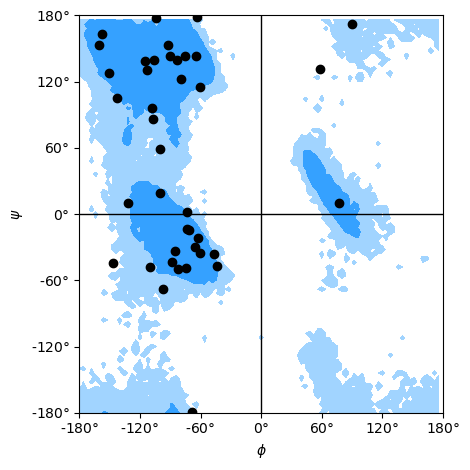

plotting Ramachandran plot of Replica 15


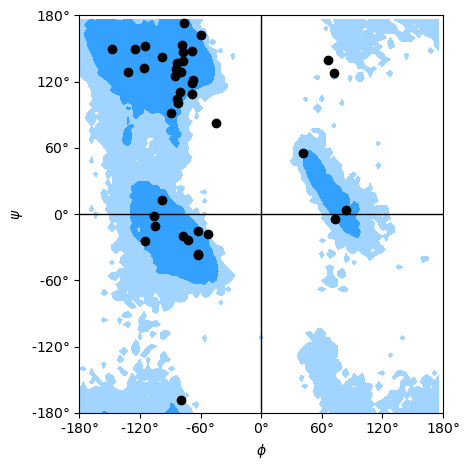

plotting Ramachandran plot of Replica 16


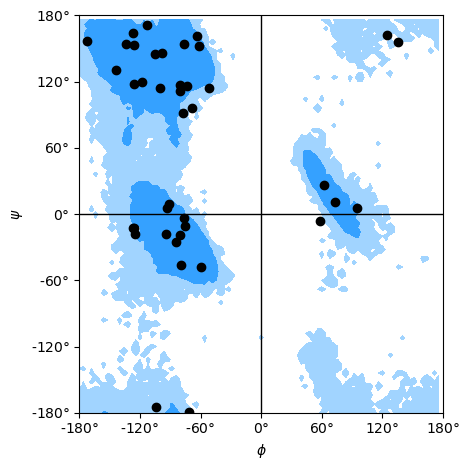

plotting Ramachandran plot of Replica 17


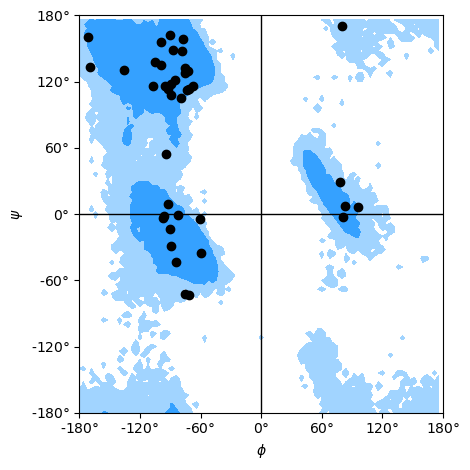

plotting Ramachandran plot of Replica 18


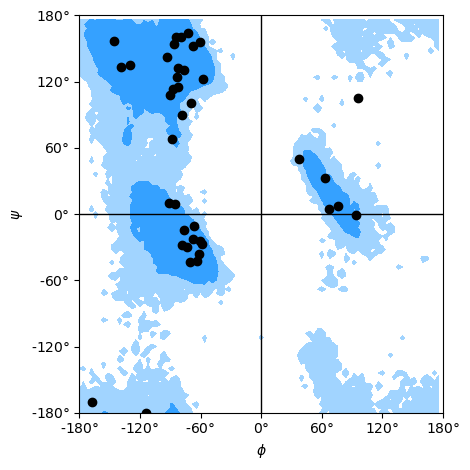

plotting Ramachandran plot of Replica 19


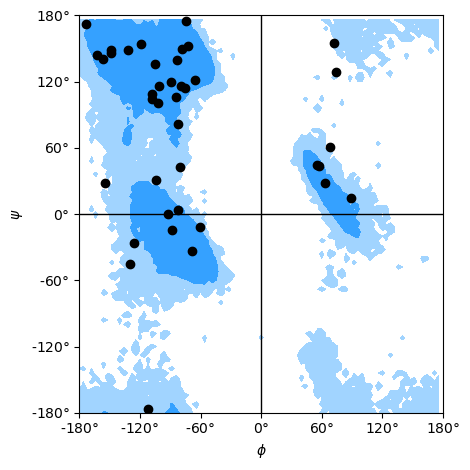

plotting Ramachandran plot of Replica 20


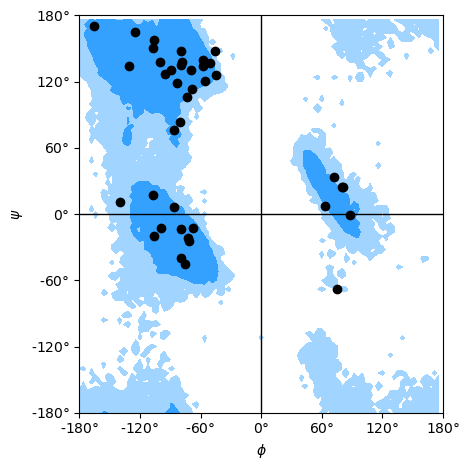

plotting Ramachandran plot of Replica 21


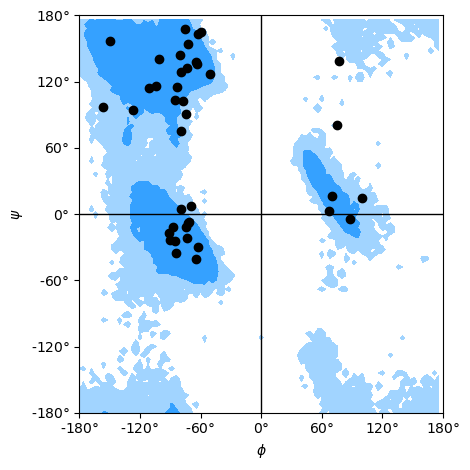

plotting Ramachandran plot of Replica 22


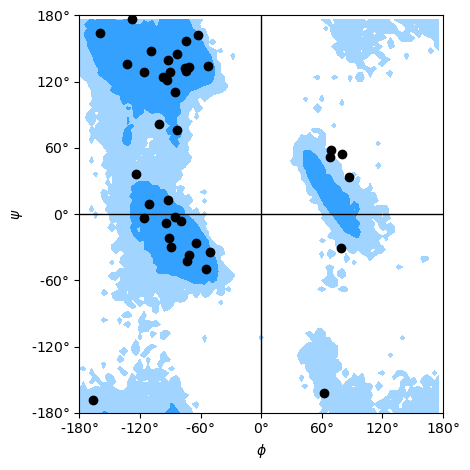

plotting Ramachandran plot of Replica 23


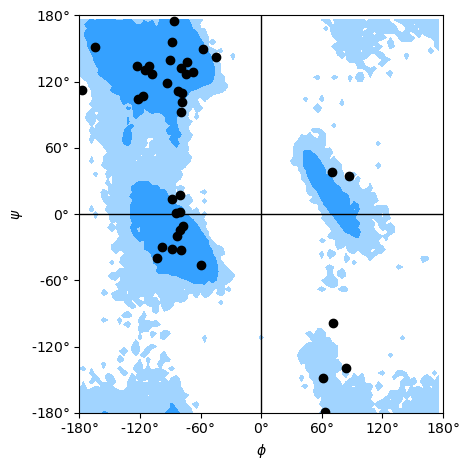

plotting Ramachandran plot of Replica 24


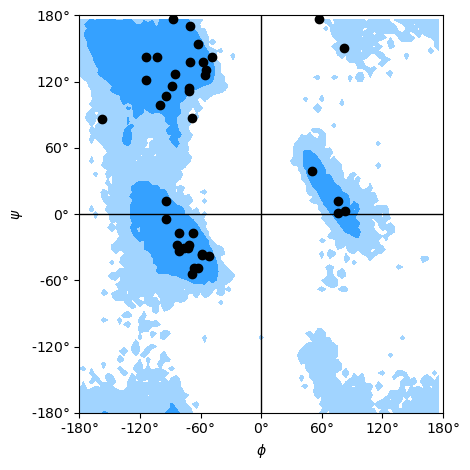

plotting Ramachandran plot of Replica 25


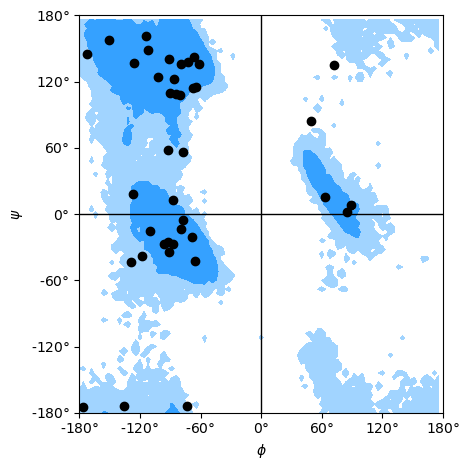

plotting Ramachandran plot of Replica 26


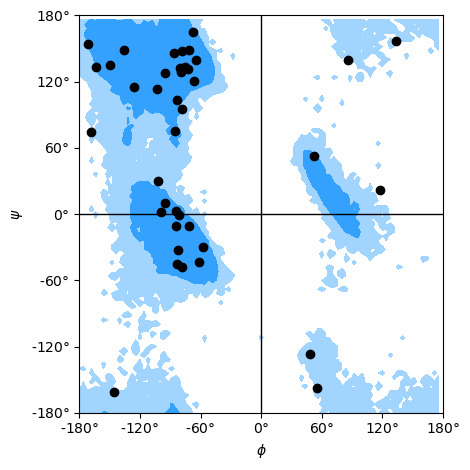

plotting Ramachandran plot of Replica 27


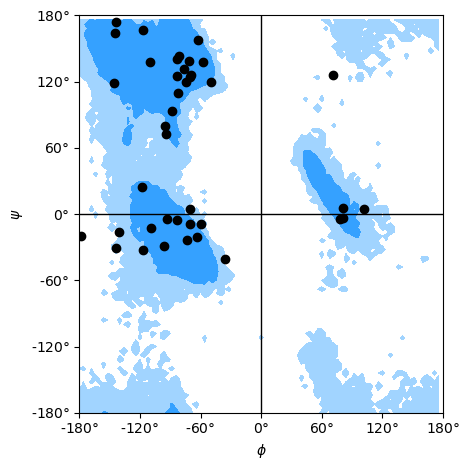

plotting Ramachandran plot of Replica 28


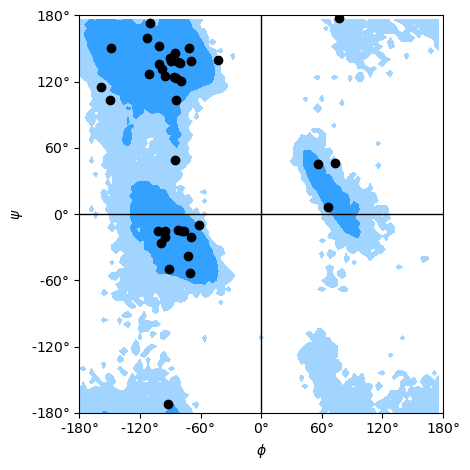

plotting Ramachandran plot of Replica 29


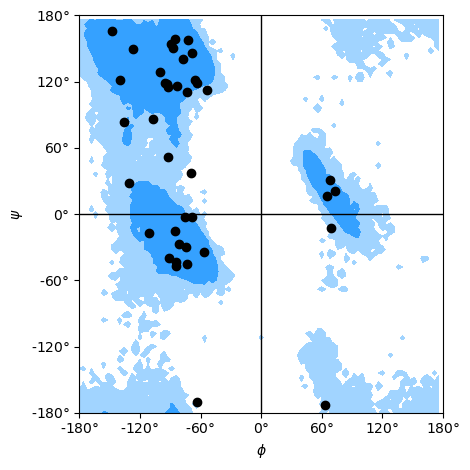

plotting Ramachandran plot of Replica 30


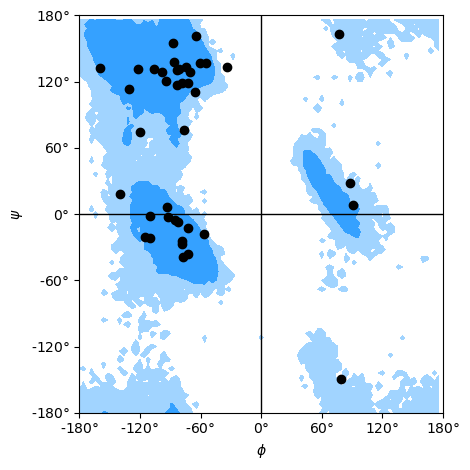

plotting Ramachandran plot of Replica 31


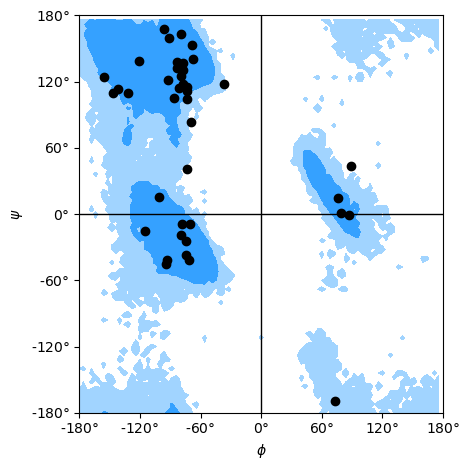

plotting Ramachandran plot of Replica 32


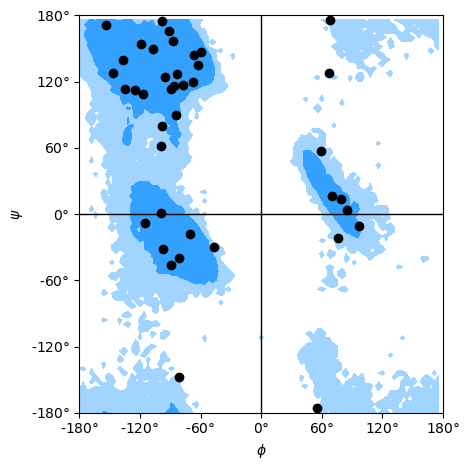

plotting Ramachandran plot of Replica 33


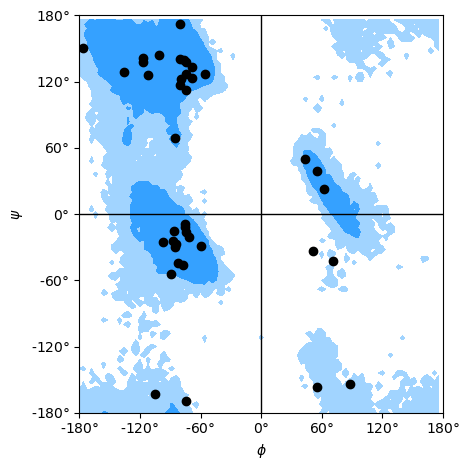

plotting Ramachandran plot of Replica 34


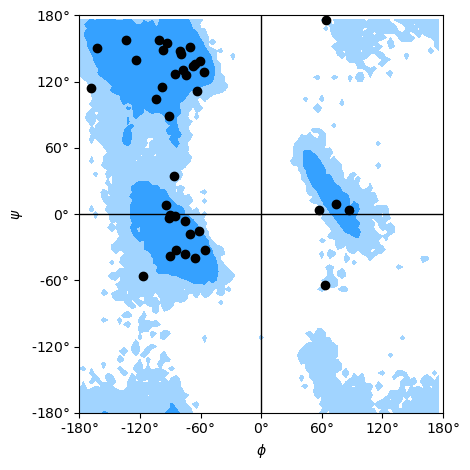

plotting Ramachandran plot of Replica 35


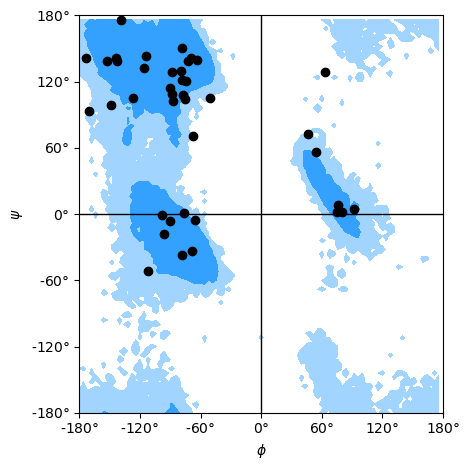

plotting Ramachandran plot of Replica 36


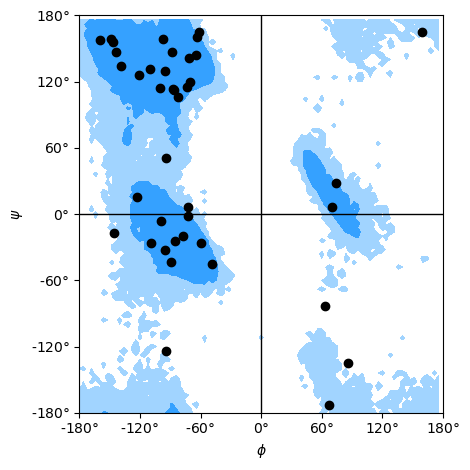

plotting Ramachandran plot of Replica 37


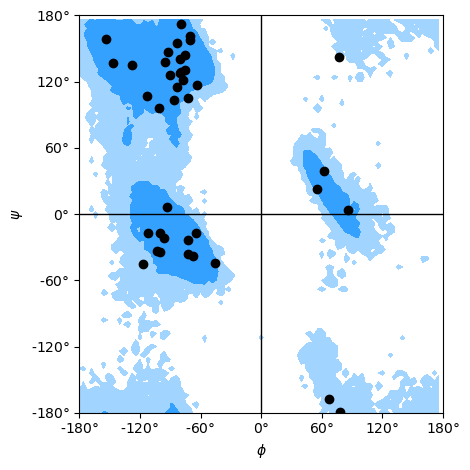

plotting Ramachandran plot of Replica 38


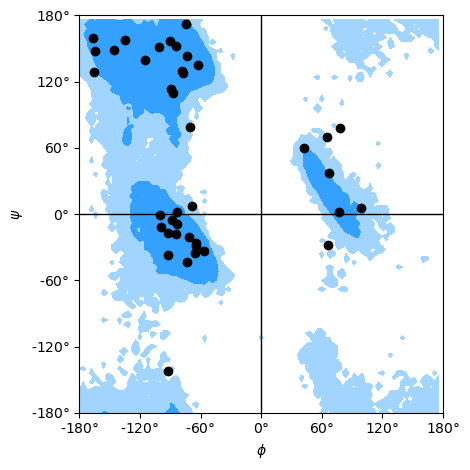

plotting Ramachandran plot of Replica 39


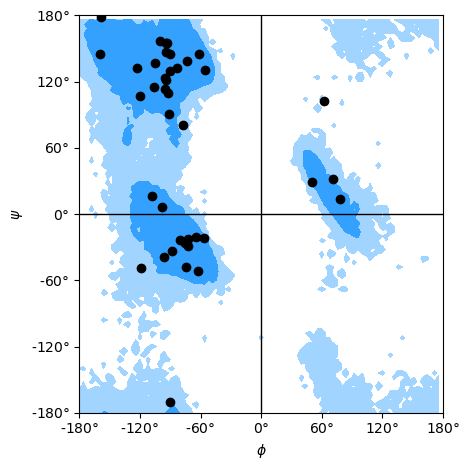

plotting Ramachandran plot of Replica 40


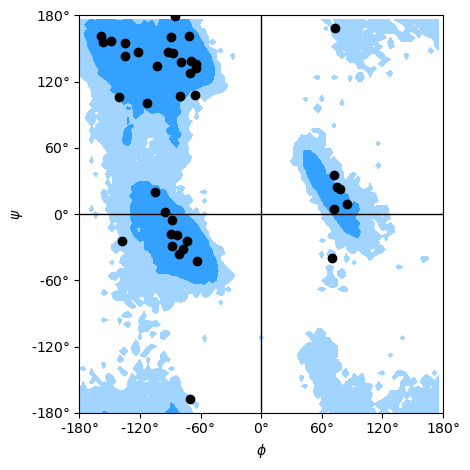

plotting Ramachandran plot of Replica 41


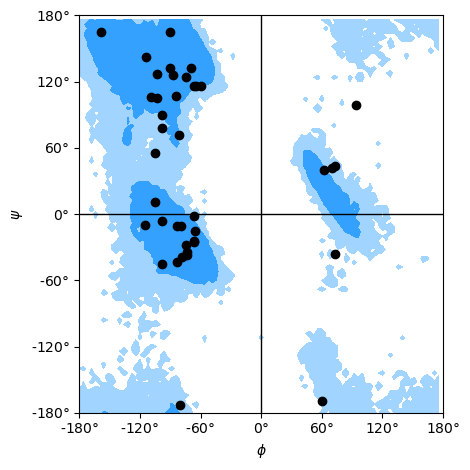

plotting Ramachandran plot of Replica 42


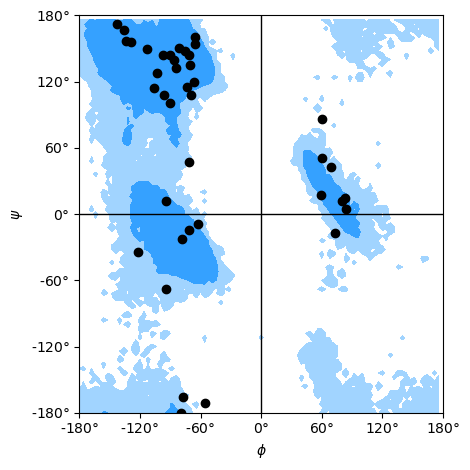

plotting Ramachandran plot of Replica 43


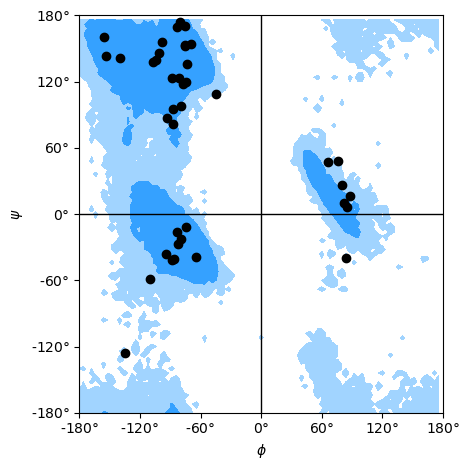

plotting Ramachandran plot of Replica 44


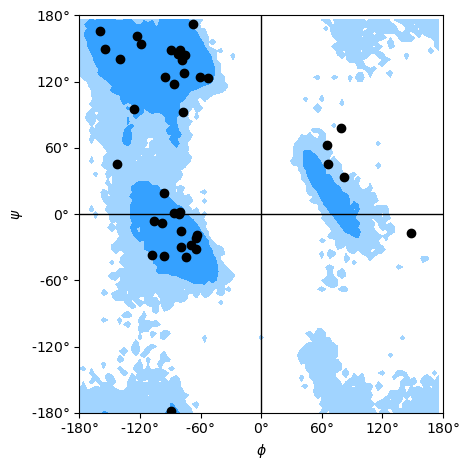

plotting Ramachandran plot of Replica 45


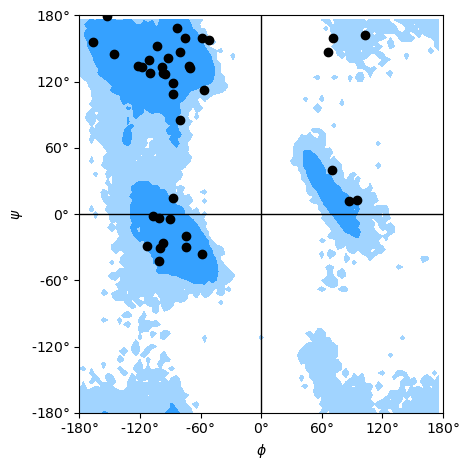

plotting Ramachandran plot of Replica 46


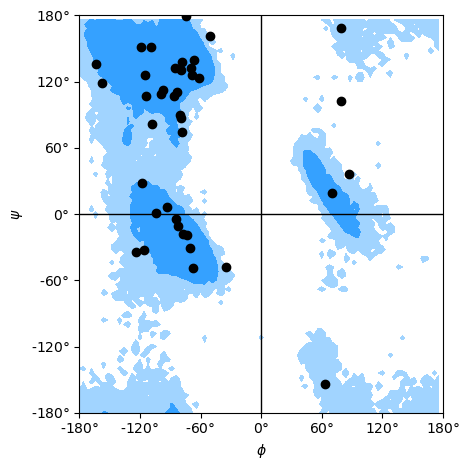

plotting Ramachandran plot of Replica 47


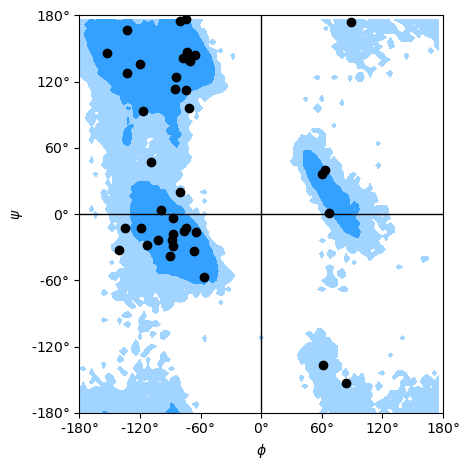

plotting Ramachandran plot of Replica 48


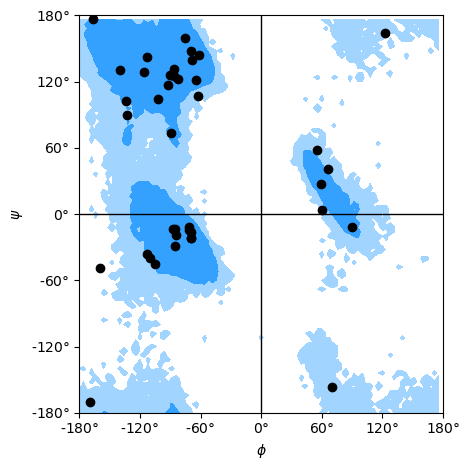

plotting Ramachandran plot of Replica 49


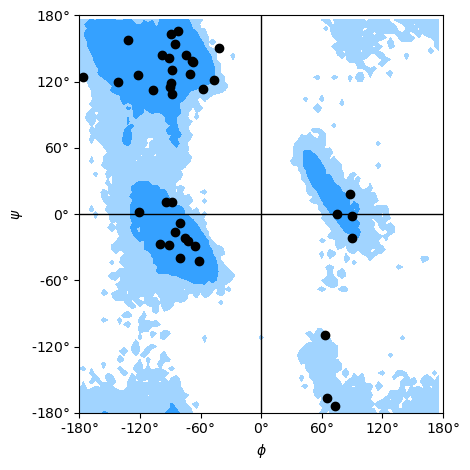

plotting Ramachandran plot of Replica 50


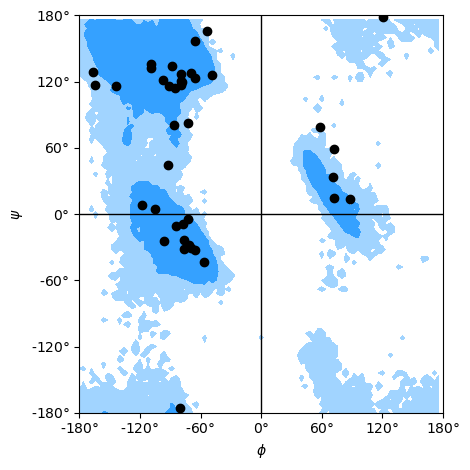

plotting Ramachandran plot of Replica 51


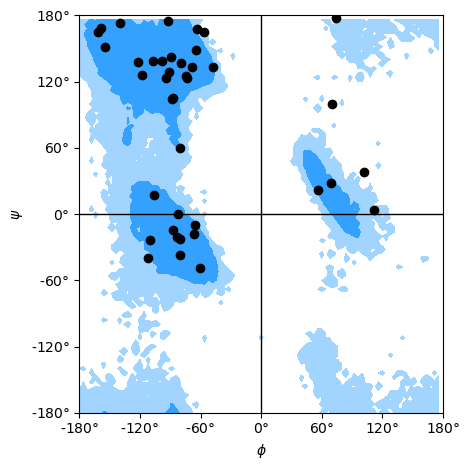

plotting Ramachandran plot of Replica 52


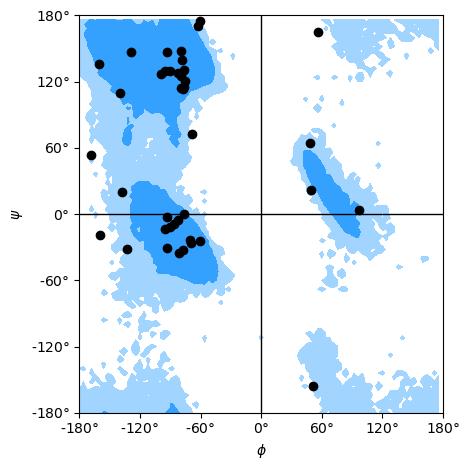

plotting Ramachandran plot of Replica 53


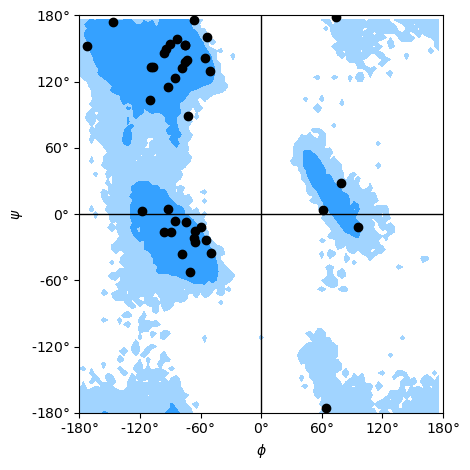

plotting Ramachandran plot of Replica 54


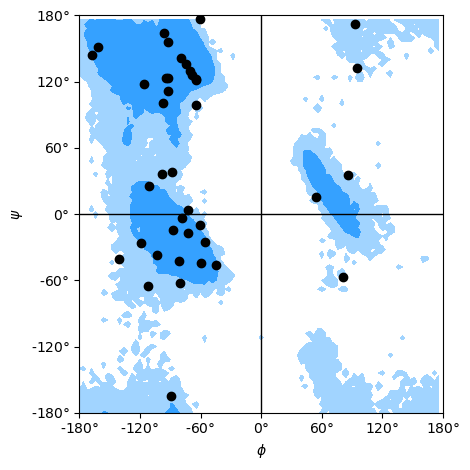

plotting Ramachandran plot of Replica 55


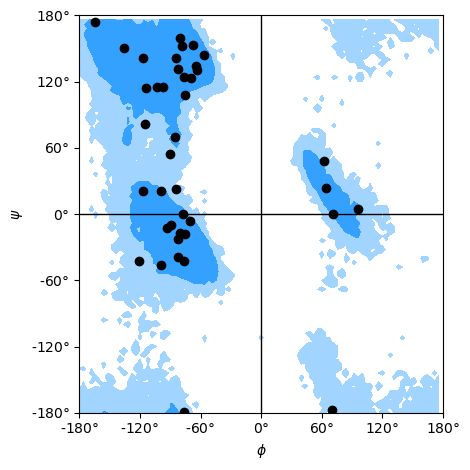

plotting Ramachandran plot of Replica 56


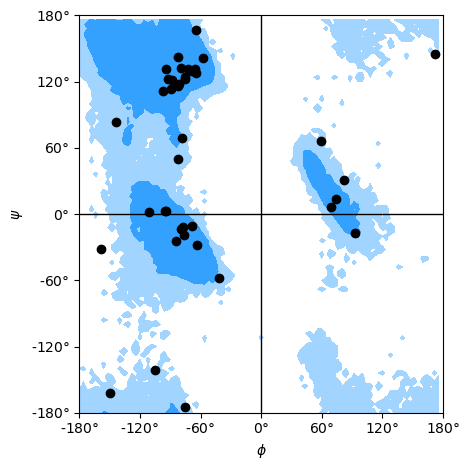

plotting Ramachandran plot of Replica 57


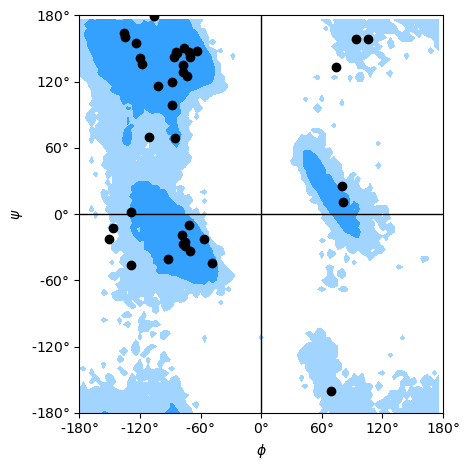

plotting Ramachandran plot of Replica 58


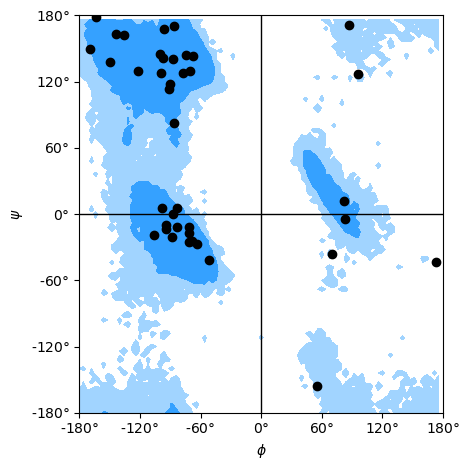

plotting Ramachandran plot of Replica 59


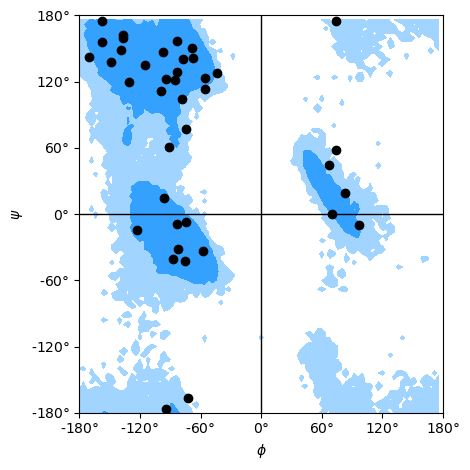

plotting Ramachandran plot of Replica 60


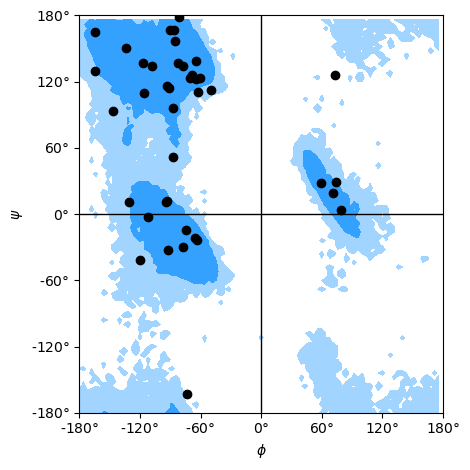

plotting Ramachandran plot of Replica 61


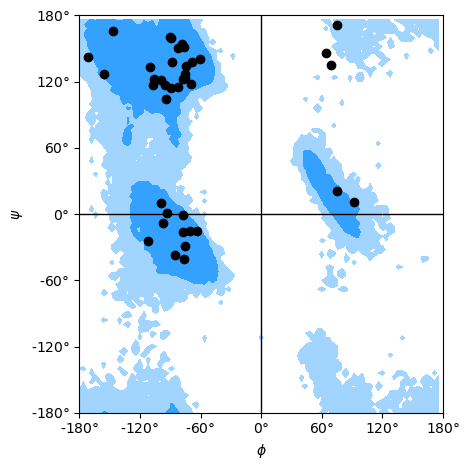

plotting Ramachandran plot of Replica 62


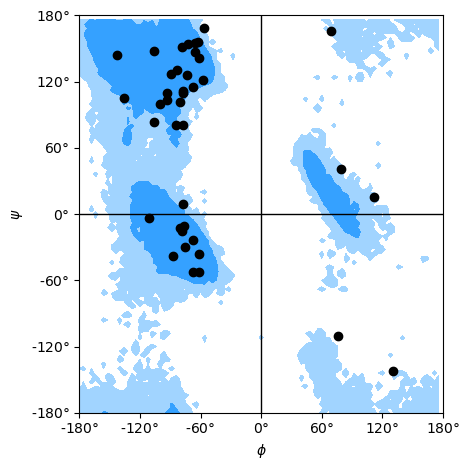

plotting Ramachandran plot of Replica 63


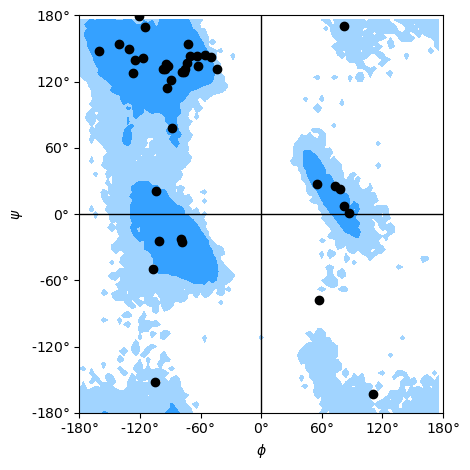

plotting Ramachandran plot of Replica 64


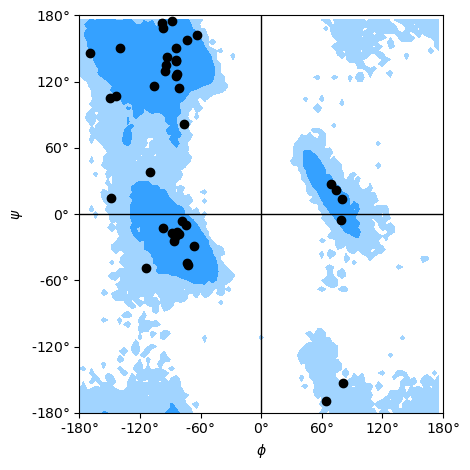

plotting Ramachandran plot of Replica 65


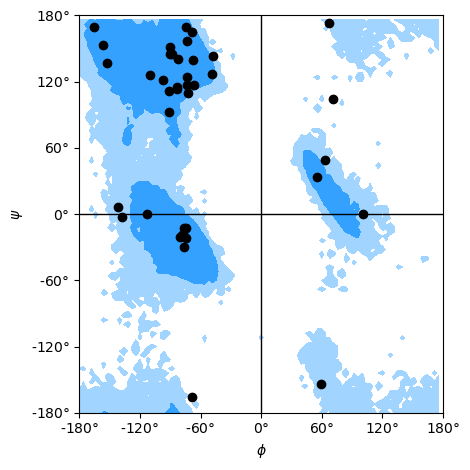

plotting Ramachandran plot of Replica 66


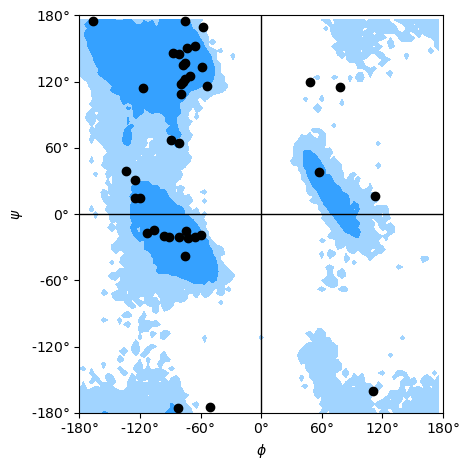

plotting Ramachandran plot of Replica 67


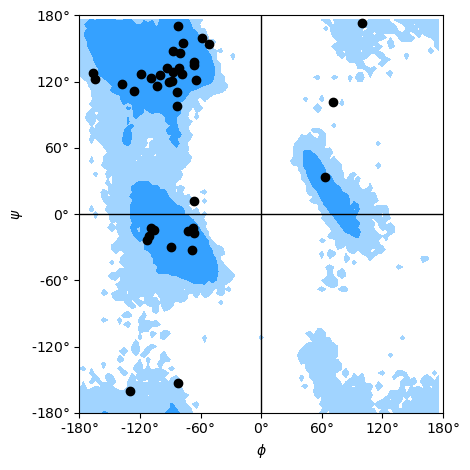

plotting Ramachandran plot of Replica 68


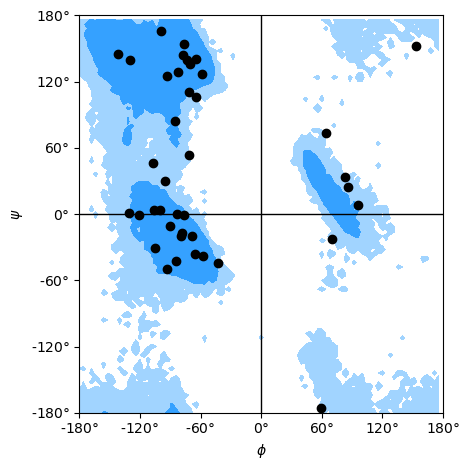

plotting Ramachandran plot of Replica 69


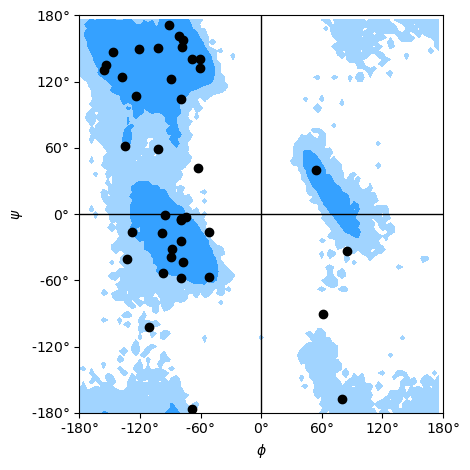

plotting Ramachandran plot of Replica 70


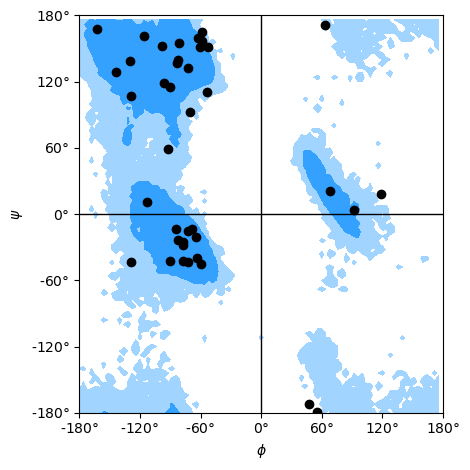

plotting Ramachandran plot of Replica 71


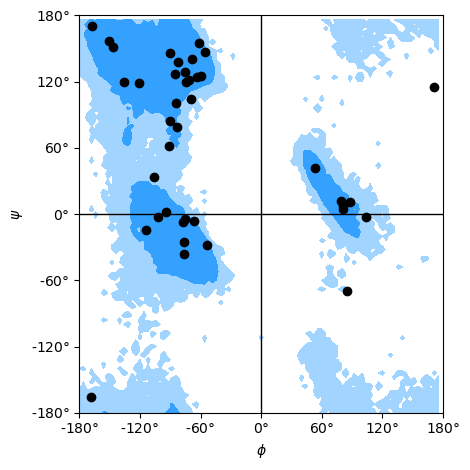

plotting Ramachandran plot of Replica 72


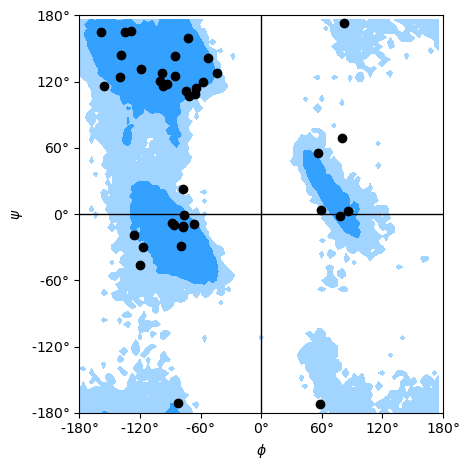

plotting Ramachandran plot of Replica 73


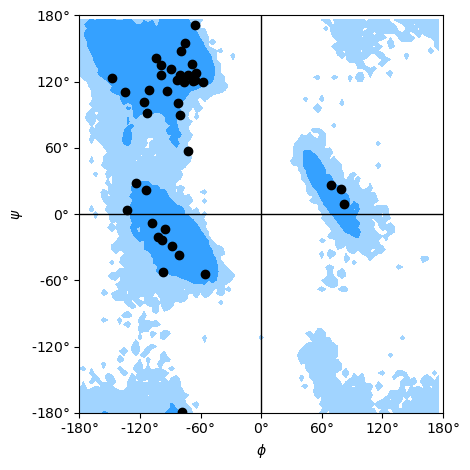

plotting Ramachandran plot of Replica 74


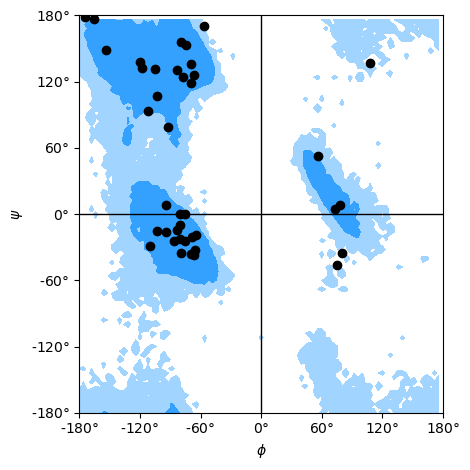

plotting Ramachandran plot of Replica 75


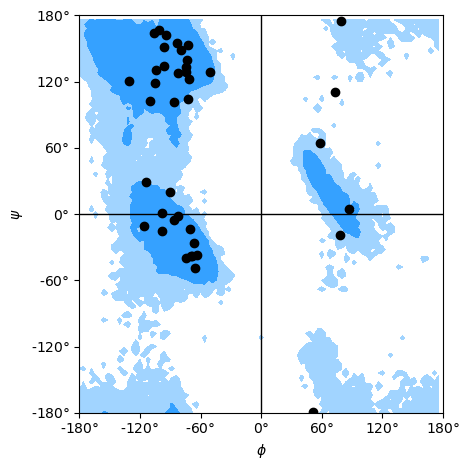

plotting Ramachandran plot of Replica 76


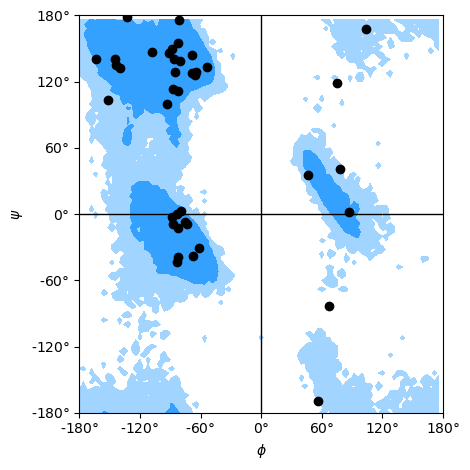

plotting Ramachandran plot of Replica 77


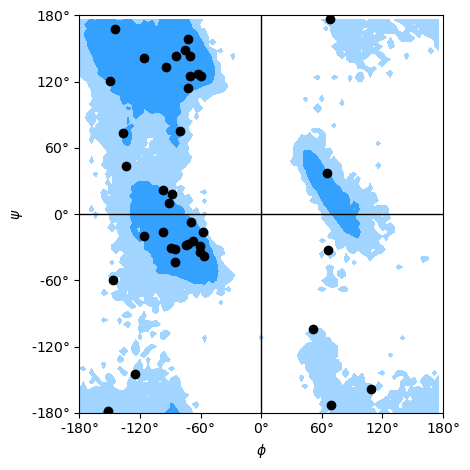

plotting Ramachandran plot of Replica 78


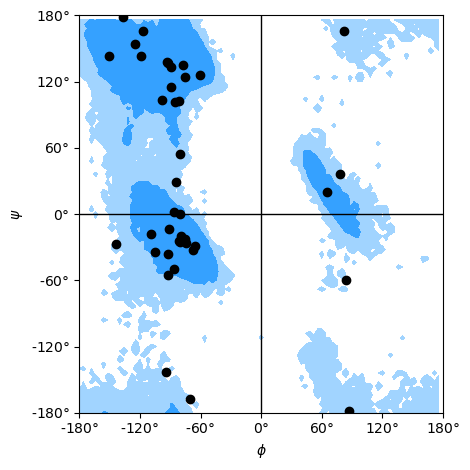

plotting Ramachandran plot of Replica 79


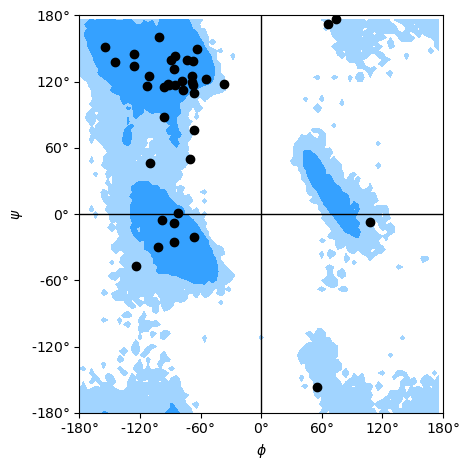

plotting Ramachandran plot of Replica 80


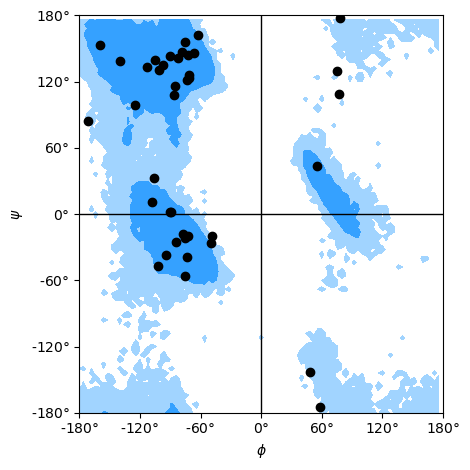

plotting Ramachandran plot of Replica 81


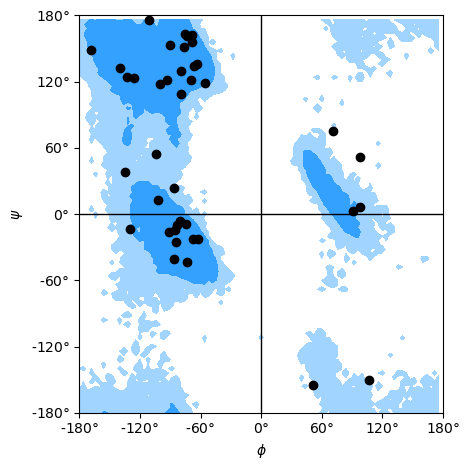

plotting Ramachandran plot of Replica 82


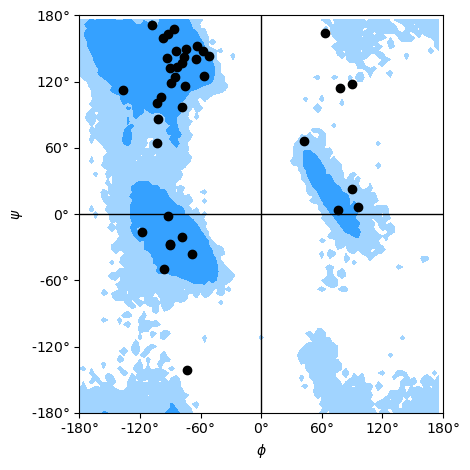

plotting Ramachandran plot of Replica 83


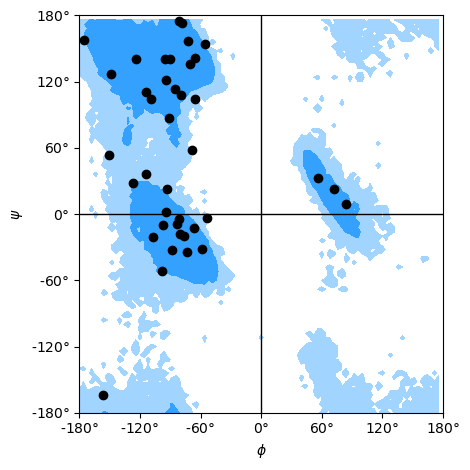

plotting Ramachandran plot of Replica 84


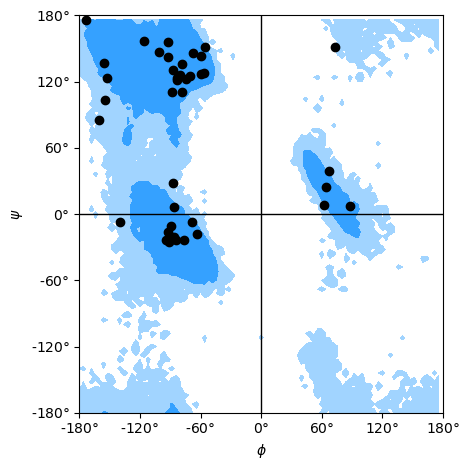

plotting Ramachandran plot of Replica 85


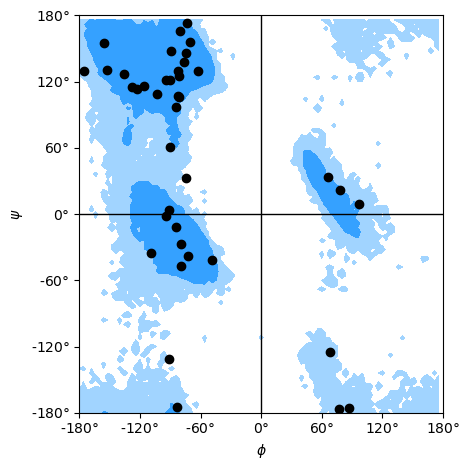

plotting Ramachandran plot of Replica 86


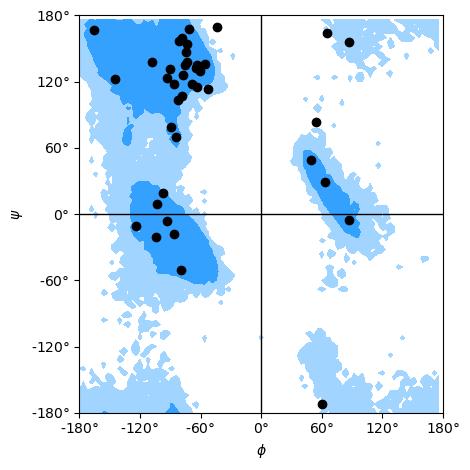

plotting Ramachandran plot of Replica 87


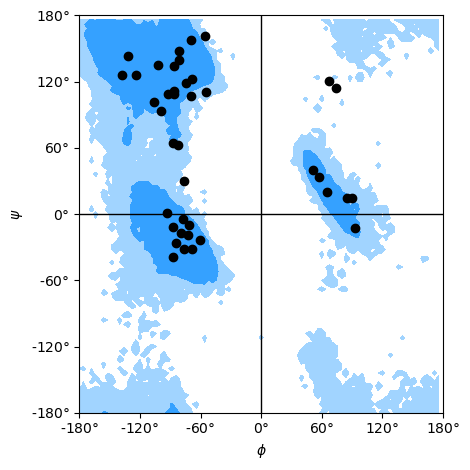

plotting Ramachandran plot of Replica 88


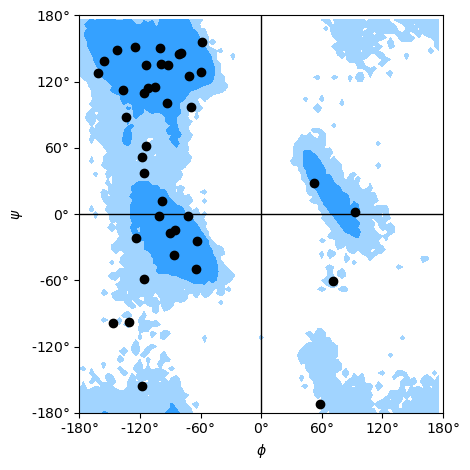

plotting Ramachandran plot of Replica 89


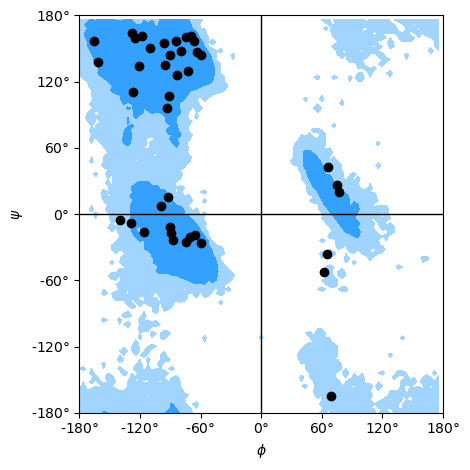

plotting Ramachandran plot of Replica 90


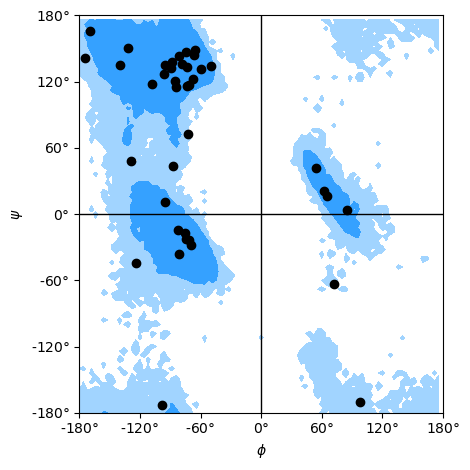

plotting Ramachandran plot of Replica 91


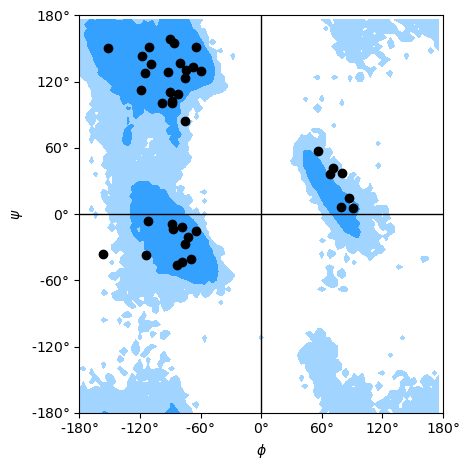

plotting Ramachandran plot of Replica 92


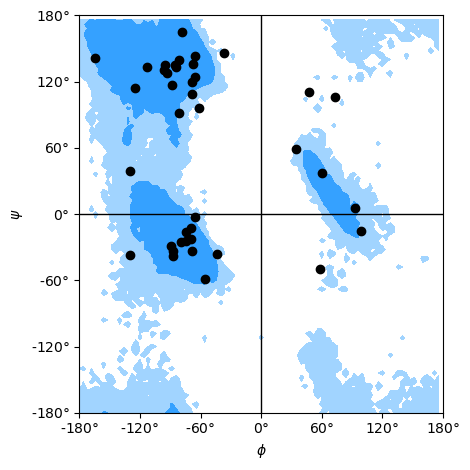

plotting Ramachandran plot of Replica 93


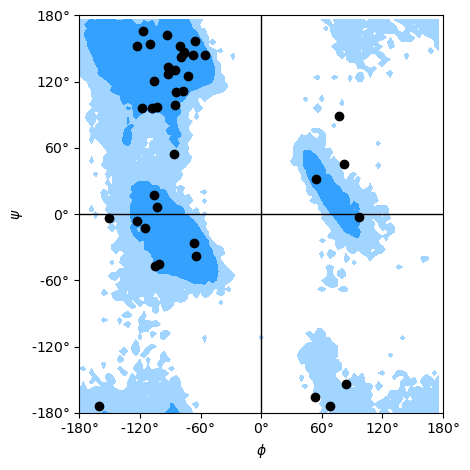

plotting Ramachandran plot of Replica 94


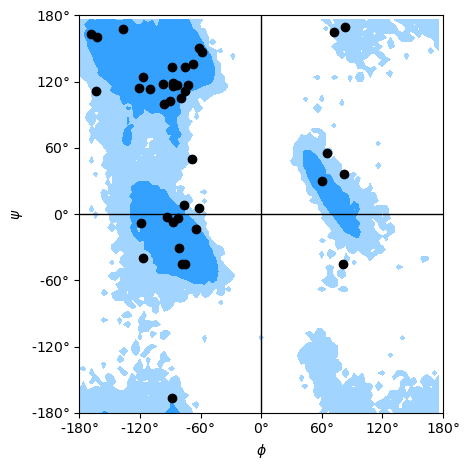

plotting Ramachandran plot of Replica 95


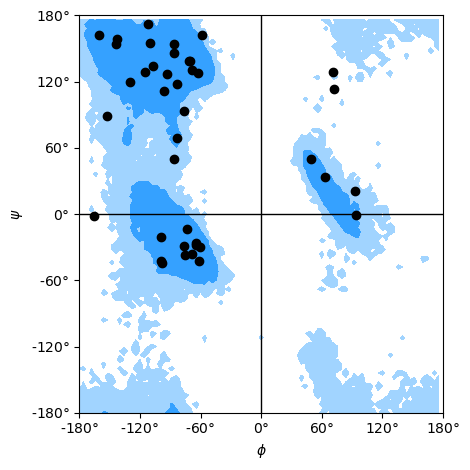

plotting Ramachandran plot of Replica 96


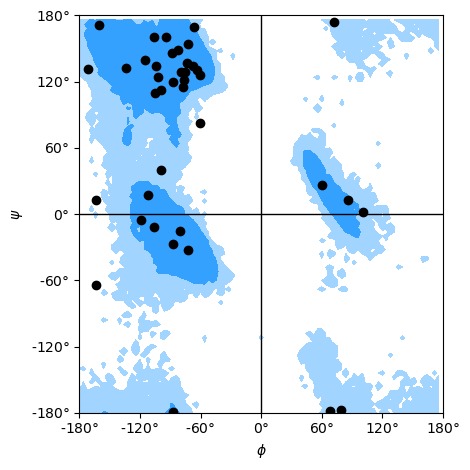

plotting Ramachandran plot of Replica 97


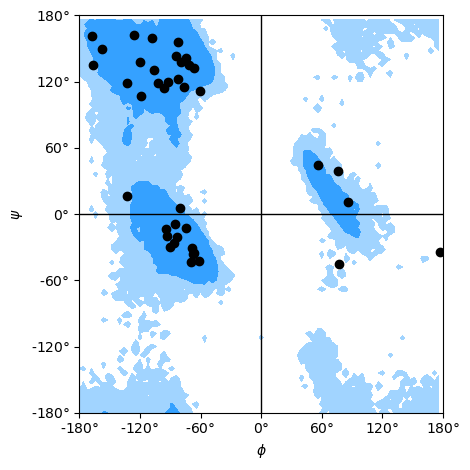

plotting Ramachandran plot of Replica 98


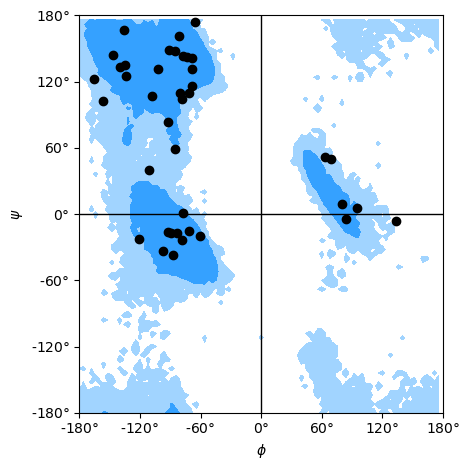

plotting Ramachandran plot of Replica 99


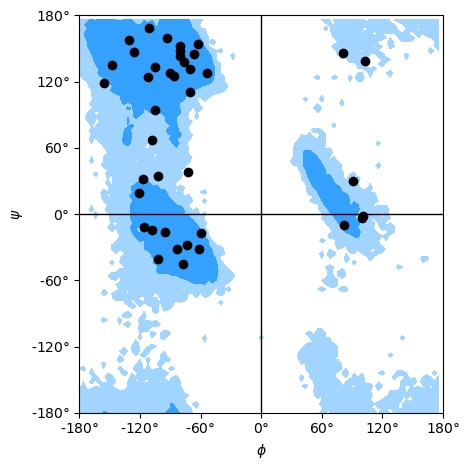

In [16]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis.dihedrals import Dihedral


# phis_indices = md.compute_phi(trj2)[0][indxs[0]]
# psis = md.compute_psi(trj2)[1][indxs[0]]
# phis = md.compute_phi(trj2)[1][indxs[0]]

# phis = phis[:38]
# psis = psis[1:]

# print(len(phis))
# print(len(psis))

# print("Ramachandran plot of replica 0")
# plt.figure(figsize=(8, 6))
# plt.scatter(phis * 180/3.14, psis * 180/3.14, s=10, color='blue', alpha=0.5)
# plt.xlim(-180, 180)
# plt.ylim(-180, 180)
# plt.xlabel('Phi (ϕ) angles')
# plt.ylabel('Psi (ψ) angles')
# plt.title('Ramachandran Plot')
# plt.grid(True)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.show()

# u = mda.Universe(f'../production/r0/only_protein.gro')
# r = u.select_atoms("resid 1-40")


# phi_selection = [(res.phi_selection()) for res in r.residues]
# psi_selection = [(res.psi_selection()) for res in r.residues]
# dihedral_selection = [d for d in psi_selection if d]

# Calculate the dihedrals
# dihedrals = Dihedral(dihedral_selection).run()

# print(dihedrals.angles)


for i in range(100):
    # Load the protein structure from a .gro file
    print(f"plotting Ramachandran plot of Replica {i}")
    u = mda.Universe(f'setup2/r{i}/npt.gro')
    r = u.select_atoms("resid 2-41")

#     print(r.residues[0].resname)
    R = Ramachandran(r).run()
#     print(R.angles)

    fig, ax = plt.subplots(figsize=plt.figaspect(1))
    R.plot(ax=ax, color='k', marker='o', ref=True)
    
#     print(R.angles[0][0])
#     print(len(R.angles[0]))
#     for j in range(len(R.angles[0])):
#         if j != 39: continue
#         ax.annotate(f"{j}", (R.angles[0][j][0], R.angles[0][j][1]), textcoords="offset points", xytext=(0,5), ha='center')
    
    fig.tight_layout()
    plt.show()
    

approved_replicas = []


In [47]:
# checking that the collective variables are correct

structure = md.load("../production/r0/npt.gro").atom_slice(range(598))

ca = []
for residue in structure.topology.residues:
    for atom in residue.atoms:
        if atom.name == "CA":
            ca.append(str(atom.index+1))

ca = ",".join(ca)

cb = [19,44,171,260,279,295,315,335,372,449,459,478,504,523,540,570,586]

for residue in structure.topology.residues:
    for atom in residue.atoms:
        if atom.name == "CB" and (atom.index +1) in cb:
                print(f"Residue {residue.resSeq} {residue.name}: Atom index {atom.index+1}")

# checking arginine, lysine, glutamic acid, and aspartic acid functional group atom numbers
for residue in structure.topology.residues:
    atom_info = [(atom.index, atom.name) for atom in residue.atoms]
    print(f"Residue {residue.resSeq} {residue.name}: Atom indices and types {atom_info}")
    
    
# all looks good!

Residue 2 ALA: Atom index 19
Residue 4 PHE: Atom index 44
Residue 12 VAL: Atom index 171
Residue 17 LEU: Atom index 260
Residue 18 VAL: Atom index 279
Residue 19 PHE: Atom index 295
Residue 20 PHE: Atom index 315
Residue 21 ALA: Atom index 335
Residue 24 VAL: Atom index 372
Residue 30 ALA: Atom index 449
Residue 31 ILE: Atom index 459
Residue 32 ILE: Atom index 478
Residue 34 LEU: Atom index 504
Residue 35 MET: Atom index 523
Residue 36 VAL: Atom index 540
Residue 39 VAL: Atom index 570
Residue 40 VAL: Atom index 586
Residue 1 ASP: Atom indices and types [(0, 'N'), (1, 'H'), (2, 'H2'), (3, 'H3'), (4, 'CA'), (5, 'HA'), (6, 'CB'), (7, 'HB3'), (8, 'HB2'), (9, 'CG'), (10, 'OD1'), (11, 'OD2'), (12, 'C'), (13, 'O')]
Residue 2 ALA: Atom indices and types [(14, 'N'), (15, 'H'), (16, 'CA'), (17, 'HA'), (18, 'CB'), (19, 'HB1'), (20, 'HB2'), (21, 'HB3'), (22, 'C'), (23, 'O')]
Residue 3 GLU: Atom indices and types [(24, 'N'), (25, 'H'), (26, 'CA'), (27, 'HA'), (28, 'CB'), (29, 'HB3'), (30, 'HB2'),

In [ ]:
# extracting standard deviation of collective variables from NPT trajectories to define the width of potentials for metadynmaics

gmx_mpi editconf -f template.gro -o template.pdb

# changed OT1 to OT in template.pdb

for i in {0..39}; do plumed driver --mf_trr r${i}/npt2.trr --plumed ../../plumed/extract_colvars.dat; done
for i in {0..38}; do mv bck.${i}.COLVAR_FOR_SIGMA r${i}/COLVAR_FOR_SIGMA; done
 

for i in {0..39}; do sed -i 1,1d r${i}/COLVAR_FOR_SIGMA; done

for i in {0..39}; do cat r${i}/COLVAR_FOR_SIGMA >> COLVAR_FOR_SIGMA_ALL; done


COLVAR_FOR_SIGMA_ALL

In [5]:

data = pd.read_table("COLVAR_FOR_SIGMA_ALL", delim_whitespace=True, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")

helix = data[1]
beta = data[2]
rgyr = data[3]
hydro = data[4]
salt = data[5]
dihcor = data[6]

print(rgyr)
print(np.std(rgyr))

helix_std = np.std(helix) / 2
beta_std = np.std(beta) / 2
rgyr_std = np.std(rgyr) / 2
hydro_std = np.std(hydro) / 2
salt_std = np.std(salt) / 2
dihcor_std = np.std(dihcor) / 2


sigma = [helix_std, beta_std, rgyr_std, hydro_std, salt_std, dihcor_std]
sigma = np.round(sigma, decimals = 2)

print(sigma)

0       1.814646
1       1.836855
2       1.842854
3       1.824686
4       1.855819
          ...   
4035    1.525855
4036    1.538037
4037    1.531900
4038    1.535686
4039    1.549213
Name: 3, Length: 4040, dtype: float64
0.2353493909186317
[0.94 0.37 0.12 0.92 5.12 1.41]


### Using sigma values: [0.94 0.37 0.12 0.92 5.12 1.41]

In [29]:
# setting grid values for Collective Variables

# 1. helix.lessthan: min = 0, max = 35 (as blocks of 6 amino acids used for calculation. 35 maximum blocks possible)
# https://groups.google.com/g/plumed-users/c/5H8Wdl0mSCg

# 2. parabetarmsd
# https://groups.google.com/g/plumed-users/c/AL-o3dlbTHE/m/5lPgjctqKgAJ
# 3 res diff: len = 9; 40-9+1 = 32
# 4 res diff: len = 10; 40-10+1 = 31
# 5 res diff: len = 11; 40-11+1 = 30
# 34 res diff: len = 40; 40-40+1 = 1
# total_segments = 528
# total = 0
# for i in range(3, 35):
#     length = 6+i
#     n_segments = 40-length+1
#     total += n_segments
# print(total)

# 2. antibetarmsd
# total = 561
# total = 0
# for i in range(2, 35):
#     length = 6+i
#     n_segments = 40-length+1
#     total += n_segments
# print(total)

# 3. radius of gyration

# gmx_mpi gyrate -f template.gro -s template.gro -o gyrate.xvg
# Rg = 3.9 nm
# setting grid max to 4

# 4. hydrophobic residue contacts
# 17C2 = 136

# 5. salt bridges
# GROUPA=[10,11,12,35,36,37,108,109,110,162,163,164,351,352,353,363,364,365]
# GROUPB=[75,76,77,78,79,80,81,250,251,252,253,432,433,434,435]
# print(len(GROUPA) * len(GROUPB))
# GRID MAX should be around 270

# 6. sum of correlation between psi dihedral angles
# max possible value is 38

# my min max:
[0, 35], [0, 1089], [0, 3.9], [0, 136], [0, 270], [0, 38]

# Gabi's min max
# 100,100,20,200,400,50
[-1, 100], [-1, 100], [-1, 20], [-1, 200], [-1, 400], [-1, 50]

270


In [ ]:
# 4. Production Run trial for optimisation

gmx_mpi grompp -f ../mdp_files/production_run.mdp -c r0/npt.gro -p ../topol.top -o r0/production.tpr -maxwarn 3
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/production_run.mdp -c r${i}/npt.gro -p ../topol.top -o r${i}/production.tpr -maxwarn 3; done
gerun gmx_mpi mdrun -multidir r{0..39} -deffnm nvt -v -maxh 11 &> 6-nvt-278-terminal.log


In [3]:
# rmsd = md.rmsd(trj2, trj2, 0)
# # print(max(rmsd))
# rmsd = md.rmsd(trj2, trj2, 0)

# # Find the index of the maximum value
# max_index = np.argmax(rmsd)
# max_index